In [1]:
%load_ext autoreload
%autoreload 2

import os 
import shutil
import numpy as n
from datetime import date
from matplotlib import pyplot as plt
import time
import napari

In [2]:
# CHANGE ME path to wherever the s2p-lbm repository is cloned on your computer
os.chdir('/home/ali/packages/s2p-lbm')
# this might work to automatically set the path, but sometimes files
# os.chdir(os.path.dirname(os.path.abspath("")))

from suite3d.job import Job
from suite3d import lbmio, utils, ui
from suite3d import tiff_utils as tfu

In [3]:
## Find all the tiffiles in the tif path
# File I/O is pipelined, so the data doesn't have to be on a fast SSD 
# single HDDs or reasonably fast network drives should work without much difference in speed 
tif_path = r'/mnt/md0/data/demo'
tifs = tfu.get_tif_paths(tif_path)

In [4]:
# Set the mandatory parameters
params = {
    # volume rate
    'fs': tfu.get_vol_rate(tifs[0]),
    # planes to analyze. 0 is deepest, 30 is shallowest (corrected for ScanImage channel IDs)
    # you should keep all the planes to do crosstalk estimation! 
    'planes' : n.arange(30),
    # Decay time of the Ca indicator in seconds. 1.3 for GCaMP6s. This example is for GCamP8m
    'tau' : 1.3
}

### "Job" structure
The unimaginatively named `Job` structure is meant to contain all of the parameters, data, logs, and results for a single recording. It will be created in the root directory provided with the given name. All intermediate and final results will be saved in this directory, so I recommend using a fast SSD for this (and moving results to slow HDD once processing is complete).

All the print statements you see (and more) are also logged in `<job dir>/logfile.txt`. If you want things to look cleaner, reduce the verbosity to 2 (full logs will still be in the logfile).

To load a previously created job (to do more processing or load results), set `create=False`. If `create=True` but there exists another job of the same name in the root directory, it will either overwrite the parameters of the previous job or throw an error (depending on the `overwrite` parameter). Note, overwriting isn't as catastrophic as it sounds since data isn't deleted and remains accessible, but you might lose the saved parameters and some metadata.

In [5]:
# Create the job
job = Job('/mnt/md0/runs','Full-Demo', tifs = tifs,
          params=params, create=True, overwrite=True, verbosity = 3)

   Found and loaded params from /mnt/md0/runs/s3d-Full-Demo/params.npy


## Initial pass
This pass takes a few files (`n_init_files`, usually ~200-300 frames is enough) and does the following:
- estimates the crosstalk coefficient between the lower set of 15 planes and the higher 15 planes
- computes the shifts between successive planes caused by the xy-shift of the light beads
- estimates the optimal number of pixels that overlap between successive strips, so they can be fused together
- calculates a "reference volume" that will be used later in registration 

In [11]:
# optional parameters for initialization
# load 1 file to initialize
job.params['n_init_files'] = 1
# If set to None, use all of the frames in the loaded init files 
# if your files are really big, set this to <300
job.params['init_n_frames'] = None

# Set to None to auto-compute the crosstalk coefficient
# You can set a float value between 0-1 (usually around 0.1-0.3) to override the calculation
job.params['override_crosstalk'] = None
# number of processors to use
job.params['n_proc_corr'] = 20

In [7]:
%%time
# This step only uses `n_init_files` files, so the  runtime will stay the same even with larger recordings
# soon this will also be gpu-ified to be faster!
job.run_init_pass()

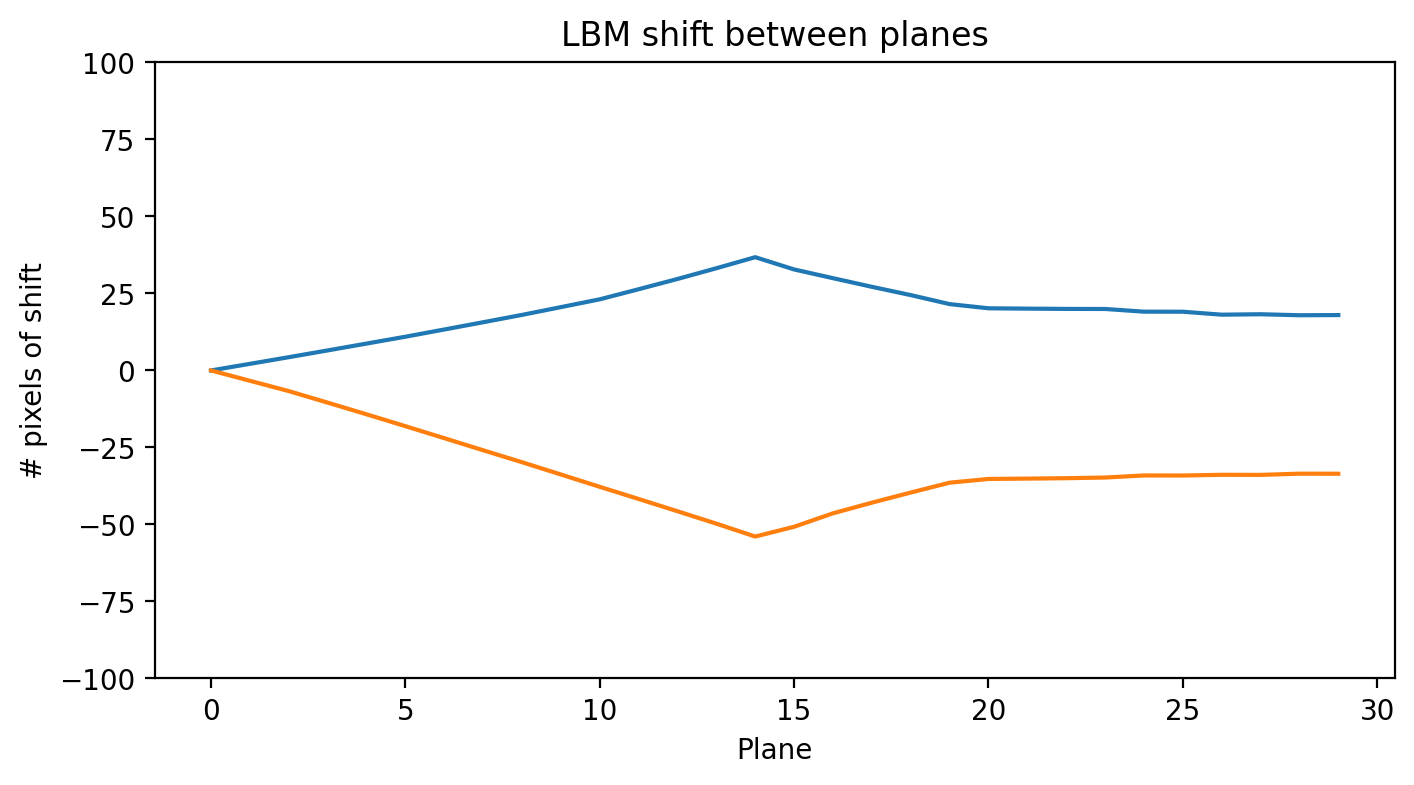

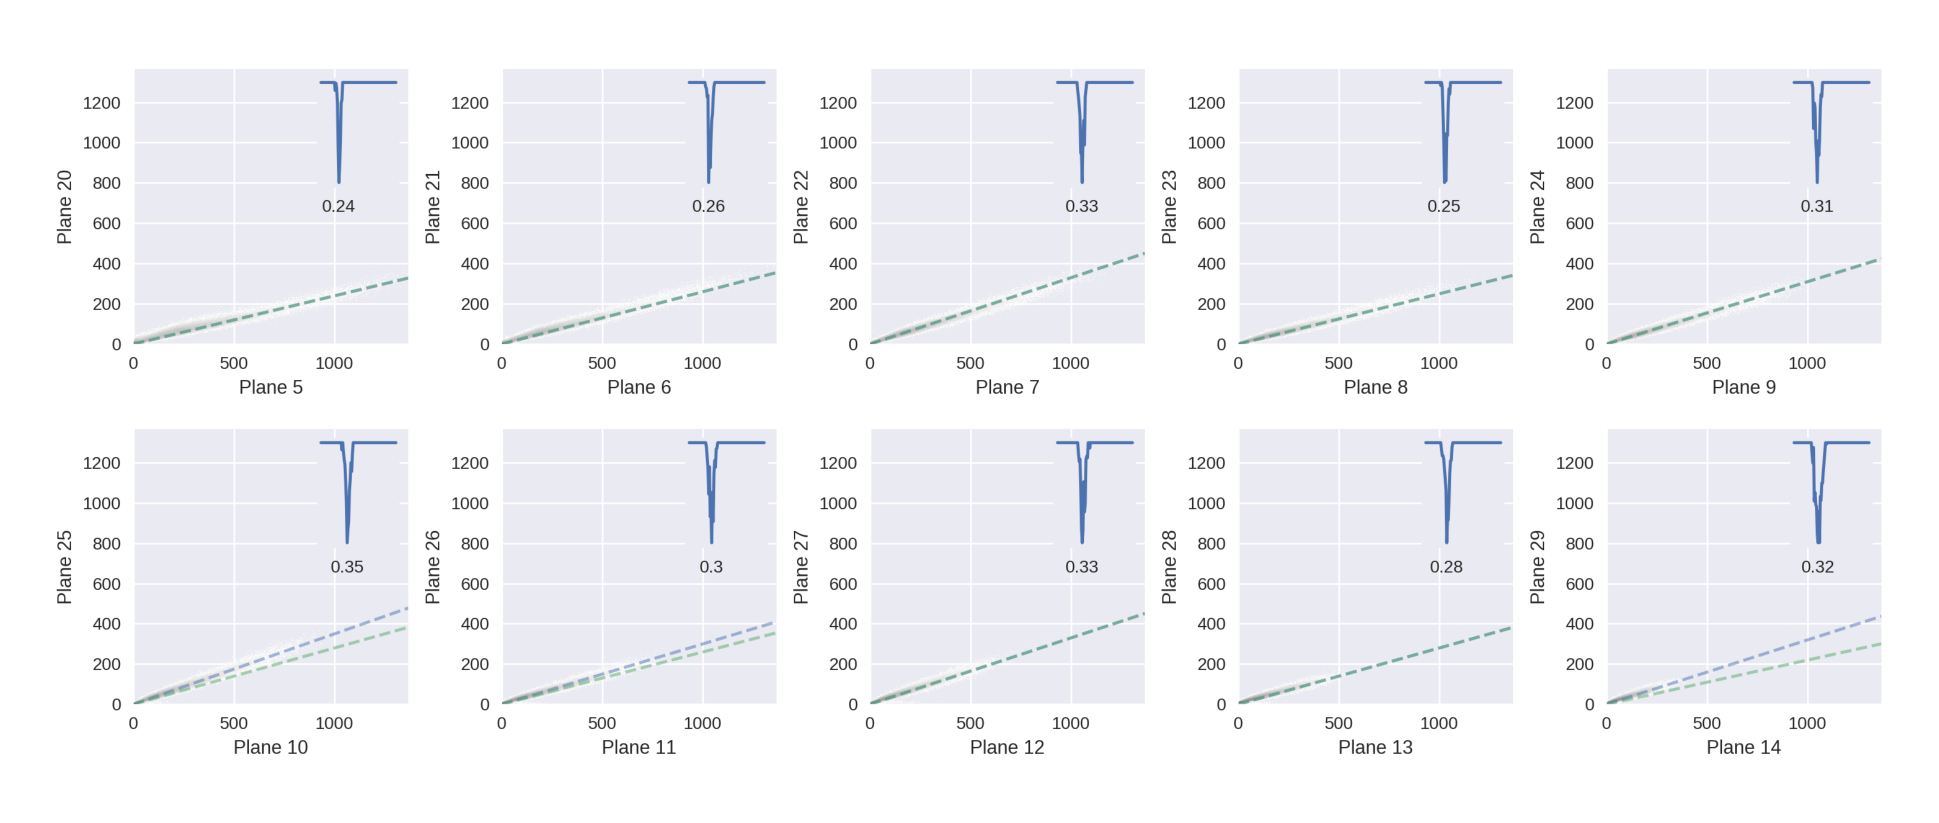

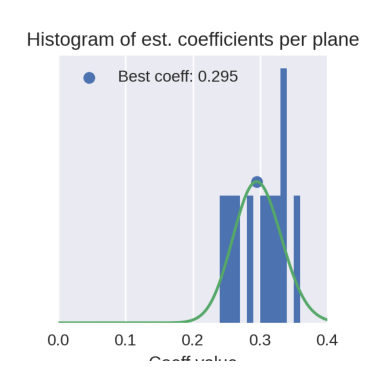

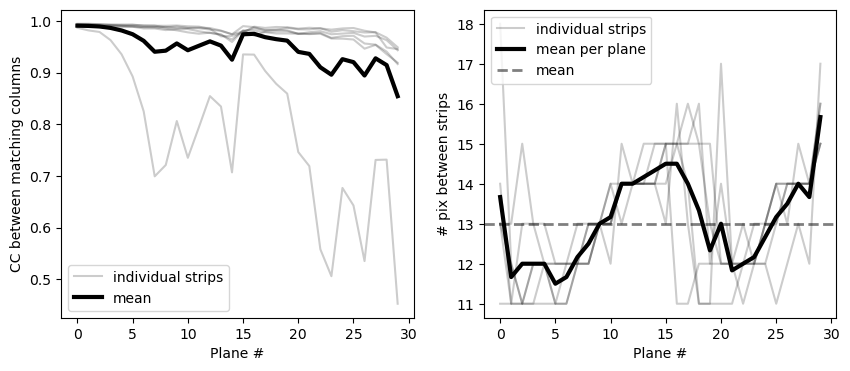

In [12]:
job.show_summary_plots()

## Registration
First, we do registration over time of the  xy-drift caused by brain movement. This is similar to Suite2P registratrion, it does rigid registration followed by non-rigid registration. This is accelerated on the GPU. Suite2P registration parameters can be changed, see `default_params.py` for a list of all parameters related to registration. After you have registered, you can load the registered fused movie into memory and take a look at the mean image. I suggest cropping the dark edges if you have any as shown in the cells below.

If you run out of gpu memory, try reducing the `gpu_reg_batchsize` parameter. I have a A4500 with 20GB memory which works well with a batchsize of 10.

In [13]:
# If you have large tiffs, split the large tiffs into files of size 100 after registration
job.params['split_tif_size'] = 100

In [14]:
%%time
job.register_gpu()

      Found dir /mnt/md0/runs/s3d-Full-Demo/registered_fused_data with tag registered_fused_data
Will analyze 3 tifs in 3 batches
   Enforcing positivity
   Launching IO thread
         Memory at batch 0.  Total Used: 080.578 GB, Virtual Available: 422.618 GB, Virtual Used: 080.578 GB, Swap Used: 000.000 GB
Loading Batch 0 of 2
      Loading /mnt/md0/data/demo/AH007_ROI3p33um_NOSCREEN_-400um_00001_00001.tif


Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

   Loaded 1 files, total 6.82 GB
   Batch 0 IO thread joined
         Memory after IO thread joinTotal Used: 087.393 GB, Virtual Available: 415.803 GB, Virtual Used: 087.393 GB, Swap Used: 000.000 GB
         Memory after movie copied from threadTotal Used: 094.221 GB, Virtual Available: 408.975 GB, Virtual Used: 094.221 GB, Swap Used: 000.000 GB
         Memory after thread memory clearedTotal Used: 087.389 GB, Virtual Available: 415.807 GB, Virtual Used: 087.389 GB, Swap Used: 000.000 GB
   Launching IO thread for next batch
      Loading /mnt/md0/data/demo/AH007_ROI3p33um_NOSCREEN_-400um_00001_00002.tif
         After IO thread launch:Total Used: 087.389 GB, Virtual Available: 415.807 GB, Virtual Used: 087.389 GB, Swap Used: 000.000 GB
      Loaded batch of size (30, 100, 1202, 1015)
      Sending frames 0-10 to GPU for rigid registration
         Loaded mov and masks to GPU for rigid reg in 1.47 sec
         Subtracting min pix vals to enforce positivity
         Subtracting crosst

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

         Loaded mov and masks to GPU for rigid reg in 1.77 sec
         Subtracting min pix vals to enforce positivity
         Subtracting crosstalk
         Fusing and padding movie
         GPU Mov of shape 30, 10, 1239, 991; 2.74 GB
         Allocating memory for shifted movie
         Registered batch in 0.03 sec
         Shifted batch in 0.30 sec
         Freeing all blocks
      Completed rigid registration in 2.55 sec
         Allocated GPU array for non-rigid reg in 0.27 sec
   Clipped movie in 0.00 sec
   Split movie into blocks in 0.00 sec
   Completed FFT of blocks and computed phase correlations in 0.00 sec
   Computed SNR and smoothed phase corrs in 0.35 sec
         Computed subpixel shifts in 0.01 sec
      Computed non-rigid shifts in 3.18 sec
      Transferred shifted mov of shape (10, 30, 1239, 991) to CPU in 0.00 sec
   Non rigid transformed (on CPU) in 2.83 sec
         After GPU Batch:    Total Used: 117.577 GB, Virtual Available: 385.619 GB, Virtual Used: 117.577

   Computed SNR and smoothed phase corrs in 0.35 sec
         Computed subpixel shifts in 0.01 sec
      Computed non-rigid shifts in 1.76 sec
      Transferred shifted mov of shape (10, 30, 1239, 991) to CPU in 0.00 sec
   Non rigid transformed (on CPU) in 2.24 sec
         After GPU Batch:    Total Used: 117.225 GB, Virtual Available: 385.971 GB, Virtual Used: 117.225 GB, Swap Used: 000.000 GB
      Sending frames 90-100 to GPU for rigid registration
         Loaded mov and masks to GPU for rigid reg in 0.50 sec
         Subtracting min pix vals to enforce positivity
         Subtracting crosstalk
         Fusing and padding movie
         GPU Mov of shape 30, 10, 1239, 991; 2.74 GB
         Allocating memory for shifted movie
         Registered batch in 0.02 sec
         Shifted batch in 0.30 sec
         Freeing all blocks
      Completed rigid registration in 1.22 sec
         Allocated GPU array for non-rigid reg in 0.20 sec
   Clipped movie in 0.00 sec
   Split movie into block

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

   Non rigid transformed (on CPU) in 5.62 sec
         After GPU Batch:    Total Used: 142.063 GB, Virtual Available: 361.133 GB, Virtual Used: 142.063 GB, Swap Used: 000.000 GB
      Sending frames 20-30 to GPU for rigid registration
         Loaded mov and masks to GPU for rigid reg in 0.65 sec
         Subtracting min pix vals to enforce positivity
         Subtracting crosstalk
         Fusing and padding movie
         GPU Mov of shape 30, 10, 1239, 991; 2.74 GB
         Allocating memory for shifted movie
         Registered batch in 0.03 sec
         Shifted batch in 0.30 sec
         Freeing all blocks
      Completed rigid registration in 1.46 sec
         Allocated GPU array for non-rigid reg in 0.20 sec
   Clipped movie in 0.00 sec
   Split movie into blocks in 0.00 sec
   Completed FFT of blocks and computed phase correlations in 0.00 sec
   Computed SNR and smoothed phase corrs in 0.35 sec
         Computed subpixel shifts in 0.01 sec
      Computed non-rigid shifts in 2.0

      Completed rigid registration in 1.18 sec
         Allocated GPU array for non-rigid reg in 0.19 sec
   Clipped movie in 0.00 sec
   Split movie into blocks in 0.00 sec
   Completed FFT of blocks and computed phase correlations in 0.00 sec
   Computed SNR and smoothed phase corrs in 0.35 sec
         Computed subpixel shifts in 0.01 sec
      Computed non-rigid shifts in 1.73 sec
      Transferred shifted mov of shape (10, 30, 1239, 991) to CPU in 0.00 sec
   Non rigid transformed (on CPU) in 2.24 sec
         After GPU Batch:    Total Used: 132.375 GB, Virtual Available: 370.821 GB, Virtual Used: 132.375 GB, Swap Used: 000.000 GB
      Concatenating movie
         Concat in 0.00 sec
         After all GPU Batches:Total Used: 132.375 GB, Virtual Available: 370.821 GB, Virtual Used: 132.375 GB, Swap Used: 000.000 GB
      Saving fused, registered file of shape (30, 100, 1239, 991) to /mnt/md0/runs/s3d-Full-Demo/registered_fused_data/fused_reg_data0001.npy
         Saved in 5.80 sec

   Non rigid transformed (on CPU) in 2.24 sec
         After GPU Batch:    Total Used: 120.078 GB, Virtual Available: 383.118 GB, Virtual Used: 120.078 GB, Swap Used: 000.000 GB
      Sending frames 60-70 to GPU for rigid registration
         Loaded mov and masks to GPU for rigid reg in 0.49 sec
         Subtracting min pix vals to enforce positivity
         Subtracting crosstalk
         Fusing and padding movie
         GPU Mov of shape 30, 10, 1239, 991; 2.74 GB
         Allocating memory for shifted movie
         Registered batch in 0.02 sec
         Shifted batch in 0.30 sec
         Freeing all blocks
      Completed rigid registration in 1.19 sec
         Allocated GPU array for non-rigid reg in 0.19 sec
   Clipped movie in 0.00 sec
   Split movie into blocks in 0.00 sec
   Completed FFT of blocks and computed phase correlations in 0.00 sec
   Computed SNR and smoothed phase corrs in 0.35 sec
         Computed subpixel shifts in 0.01 sec
      Computed non-rigid shifts in 1.7

In [11]:
# if GPU fails, the following *should* work
# job.register()

In [39]:
mov_full = job.get_registered_movie()
im_full = mov_full.mean(axis=1).compute()

In [41]:
# find crop values that minimize dark zones - check planes 0 and 15 in the following cell to 
# make sure you're not cutting out parts of the brain
crop = ((0,18), (100,1100), (100, 950))

(<Figure size 1200x900 with 1 Axes>,
 <Axes: >,
 <matplotlib.image.AxesImage at 0x7fd7c7fa6a90>)

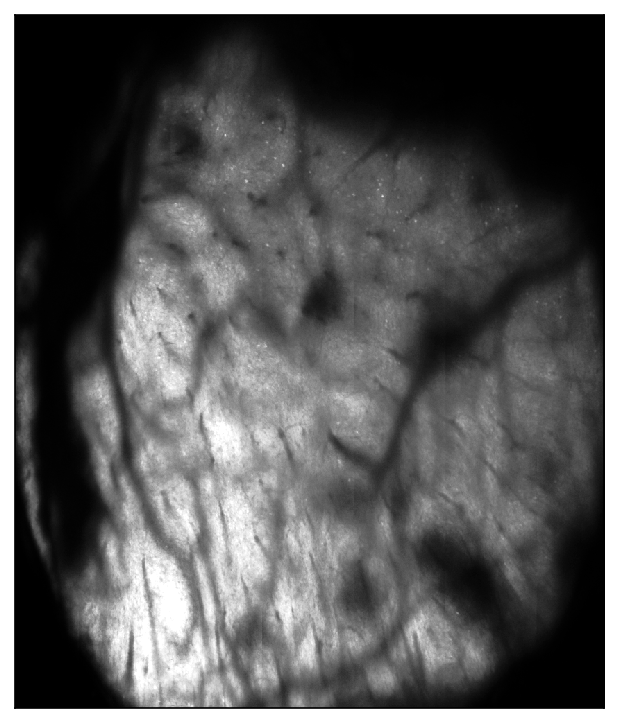

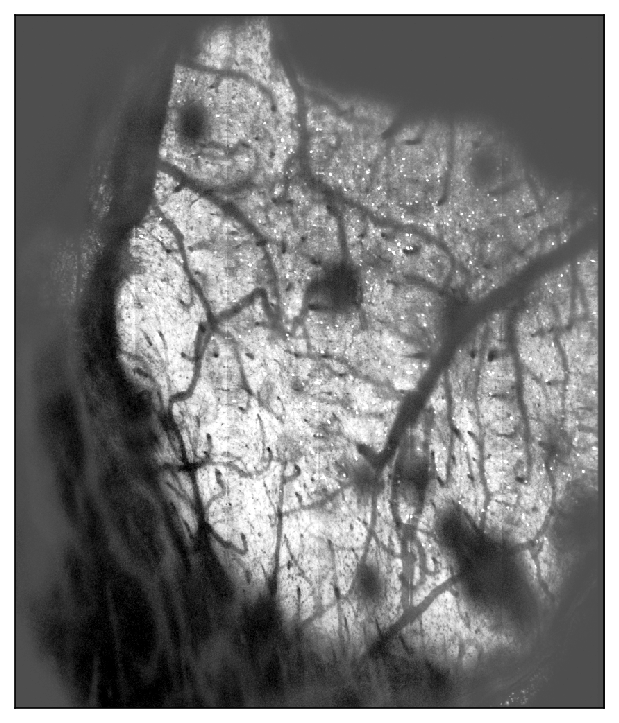

In [17]:
tfu.show_tif(im_full[0,crop[1][0]:crop[1][1], crop[2][0]:crop[2][1]])
tfu.show_tif(im_full[15,crop[1][0]:crop[1][1], crop[2][0]:crop[2][1]])

## Calculating the correlation map

The correlation map is the most important part of the cell detection process. It spatially and temporally filters the denoised movie, normalizes it, thresholds it, and accumulates it over time to create a volume where cells should be made more visible and neuropil is removed.

**You should tune some of these parameters for your data**, each described below. To enable easy tuning, there is a **parameter sweep interface** that can try many combinations for a subset of the movie quickly, and visualize the results (you will find this below). 

Correlation map improves the more frames you have!

In [18]:
# spatial filter sizes for neuropil subtraction, and cell detection
# npil_filt is a low_pass filter that attempts to remove any features larger than the filter size (neuropil!)
# conv_filt_xy is a high_pass filter that amplifies any features that are smaller than ~2x the filter size (cells!)
# these values worked well for me with ~4um xy pixel spacing and ~15 um z pixel spacing, for detecting mouse somata
# When you change resolution, or if you're trying to detect smaller things, you will need to adjust these values
# because the units here are _pixels_, not microns!
job.params['conv_filt_type'] = 'gaussian'
job.params['conv_filt_xy'] = 1.0
job.params['conv_filt_z'] = 1.0
job.params['npil_filt_type'] = 'unif'
job.params['npil_filt_xy'] = 5.0
job.params['npil_filt_z']=  1.5

# normalization exponent, should be around 1. 
# If you find blood vessels or the background being too bright in the correlation map, reduce it to ~0.7-0.8! 
job.params['sdnorm_exp']= 0.8

# threshold applied to the normalized, filtered movie before it is accumulated into the correlation map
# if you increase it, the background will become darker (which is good!), however at some point you will
# start excluding dimmer cells (which is bad!)
job.params['intensity_thresh'] : 0.2

## Compute parameters 
# number of frames to compute at one iteration 
# (any value above ~100-200 shouldn't affect results, 
# decrease if you have RAM issues or if SVD reconstruction gets stuck on "Sending all blocks to dask to compute")
job.params['t_batch_size'] = 300
# number of processors to use when calculating the correlation map
job.params['n_proc_corr'] = 70
# number of frames per smaller batch within the batch, should be ~t_batch_size / n_proc_corr, but above ~5
job.params['mproc_batchsize'] = 5


In [42]:
mov = mov_full[crop[0][0]:crop[0][1], :,crop[1][0]:crop[1][1], 
               crop[2][0]:crop[2][1]]

In [20]:
%%time
(vmap, mean_img, max_img), __, __ = job.calculate_corr_map(mov = mov)

   Updated main params file
      Found dir /mnt/md0/runs/s3d-Full-Demo/mov_sub with tag mov_sub
   Saving mov_sub to /mnt/md0/runs/s3d-Full-Demo/mov_sub
   Using conv_filt: gaussian, 1.00, 1.00
   Using np_filt: unif, 1.50, 5.00
   Created files and dirs for 1 batches
      Running batch 1 of 1
         Will process 300 frames (0-300, t_batch_size: 300)
      Loaded and swapped, idx 0 to 300
      Calculating corr map
         Rolling mean filter
         Stdev over time
         Sharr creation
         Sub and conv
         Vmap
   Calculated corr map in 103.91 seconds
      Saving to /mnt/md0/runs/s3d-Full-Demo/iters/batch0000
CPU times: user 42.9 s, sys: 54.5 s, total: 1min 37s
Wall time: 1min 55s


### Optional: sweep correlation map parameters

You can do a parameter sweep here to find the best parameters for the correlation map on a time-subset of the data, and then re-run the correlation map computation on the full data again afterwards

In [32]:
# Pick the parameters you want to sweep, and enter them in the tuples.
# It will do all combinations of parameters, so if you have many parameters it will be many combinations! 

params_to_sweep = {
    'intensity_thresh' : (0.2, 0.3),
    'n_svd_comp' : (50,), # if you have multiple values here, make sure you pass mov=svd_info
    'conv_filt_xy': (0.7,1.0,),
    'npil_filt_xy': (5.0,),
    'conv_filt_z' : (1.0,),
    'npil_filt_z' : (1.5,),
    'sdnorm_exp' : (0.7,0.8)
}

sweep_summary = job.sweep_params(params_to_sweep, mov = mov,testing_dir_tag='sweep-full',
                           do_vmap=True, all_combinations=True, n_test_iters = 1)
# use this to access older sweep results
# sweep_summary = n.load(os.path.join(job.dirs['sweep-full'], 'sweep_summary.npy'),allow_pickle=True).item()


      Found dir /mnt/md0/runs/s3d-Full-Demo/sweep-full with tag sweep-full
   Created dir /mnt/md0/runs/s3d-Full-Demo/sweep-full/sweep-full-comb_00000 with tag sweep-full-comb_00000
   Created dir /mnt/md0/runs/s3d-Full-Demo/sweep-full/sweep-full-comb_00001 with tag sweep-full-comb_00001
   Created dir /mnt/md0/runs/s3d-Full-Demo/sweep-full/sweep-full-comb_00002 with tag sweep-full-comb_00002
   Created dir /mnt/md0/runs/s3d-Full-Demo/sweep-full/sweep-full-comb_00003 with tag sweep-full-comb_00003
   Saving summary for 4 combinations to /mnt/md0/runs/s3d-Full-Demo/sweep-full/sweep_summary.npy
Running combination 01/04Total Used: 149.260 GB, Virtual Available: 369.613 GB, Virtual Used: 133.583 GB, Swap Used: 015.677 GB
   Summary dict size: 00 GB
      Combination params: comb00000-params-intensity_thresh_0.200-n_svd_comp_50.000-conv_filt_xy_1.000-npil_filt_xy_5.000-conv_filt_z_1.000-npil_filt_z_1.500-sdnorm_exp_0.700
      Saving to tag sweep-full-comb_00000 at /mnt/md0/runs/s3d-Full-D

In [34]:
v = job.vis_vmap_sweep(sweep_summary)

[2, 1, 1, 1, 1, 1, 2]
(2, 1, 1, 1, 1, 1, 2, 18, 1000, 850)


In [40]:
# reminder: you should set all parameters that you swept back to the values you want explicitly before re-computing the correlation map
# because the global values of the parameters are updated during the sweep!

## Detection
Now that we have a correlation map, we can segment the cells. The algorithm is similar to suite2p, it does the following:
1. Choose the peak value on the correlation map, and set this pixel as your _seed cell_
2. Identify the _active frames_ of the candidate cell by taking all frames where the activity of the cell is greater than a threshold (`activity_thresh`) or have activity above a certain percentile (`percentile`) 
3. Look at the activity of all neighboring pixels of the _seed cell_ during the _active frames_ of the seed cell. If a candidate pixel's activity is similar to the activity of the _seed cell_ (similarity above `extend_thresh`), include the pixel in the _seed cell_.
4. Repeat steps 2-3 until you've grown the cell as much as you can
5. Remove the cell from the correlation map
6. Find the next largest peak of the correlation map, take this as your seed cell and repeat steps 2-6
7. Stop when the peak value of the remaining correlation map is below a user-specified threhsold (`peak_thresh`)
Two main improvements over Suite2p: first, this is done in 3D. Second, it is parallelized to be much faster, as it works on patches of the movie separately!

**The most important variable that you *must* set is `peak_thresh`**. To do this, use the cell below to visualize the correlation map (`vmap` for short) using napari. Use the contrast sliders to find a minimum value where all spots above this value look like they might be cells. I find it useful to set the range to be very small, all pixels above the minimum are basically white. You should try to get rid of most of the obvious noise (e.g. artifacts at edges or around blood vessels, specks of single-pixel white spots, stuff outside the brain). It is not critical to exclude everything, you can be generous here and remove ROIs based on other criteria later. However, if you are too generous, you'll end up with too many pixels above the threhsold and your detection will take forever, with a lot of extra junk cells. I recommend starting a little conservative, and then push the limits. 

**Other useful variables**: When you have long enough recordings, 0.2 for `extend_thresh` is OK. However, if you have only a very short recording, or you find many cells that are much larger than they should be (with large, sprinkly footprints that extend way beyond the cell), or you have large cloudy blobs of noise being picked up as cells, increase `extend_thresh`. `activity_thresh` and `percentile` work together, usually it's good enough to just pick one and change it. If you have few frames, or you feel like you have low signal, it's better to set these to be lower, so you include more frames when evaluating a cell. However, if you can afford to, it's good to keep them high (`activity_thresh` around 10, `percentile` around 99.0), because then sparsely-firing cells will be picked up easier. Play around and see!

**To make it faster to try parameters, you can run the detection only on a subset of the patches**. By default the movie is split into ~100 patches (I think), but if you pass `job.patch_and_detect(do_patch_idxs=(10,20,50,80))` then the detection will only run on the specified patches.

**Detection always works better with more frames!** 300 frames is a very small number, so don't expect it to work perfectly on this demo.

In [21]:
# visualize the correlation map
# here you can identify the best "peak_thresh"
# play with the contrast limits of vmap until only cells are visible
# the lower contrast limit should be used as "peak_thresh"

# v = napari.view_image(vmap)
# v.add_image(mean_img)

In [23]:
vmap = job.load_iter_results(-1)['vmap']

   Loading from /mnt/md0/runs/s3d-Full-Demo/iters/batch0000


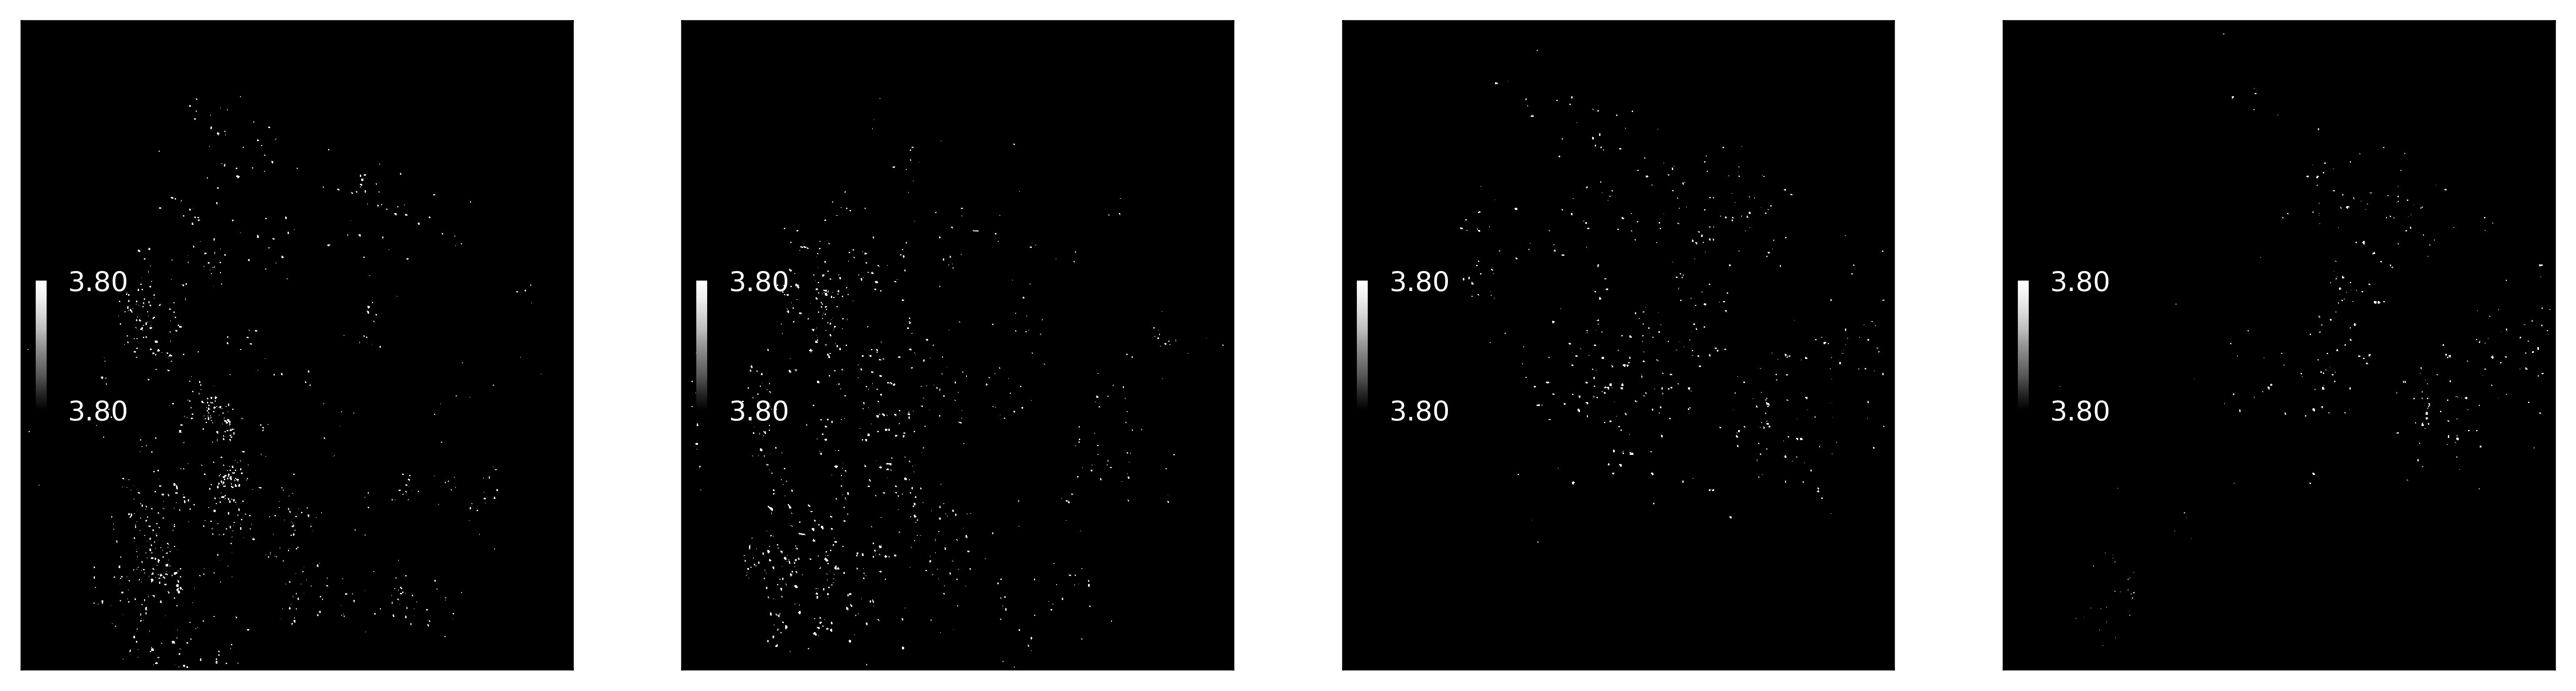

In [27]:
# alternatively, you can just plot it without napari
thresh = 3.8
vminmax = (thresh, thresh + 0.001)
f,axs = plt.subplots(1,4, figsize=(15,5), dpi=500)
for i,zidx in enumerate((0,10,15,17)):
    tfu.show_tif(vmap[zidx], cbar=True, cbar_fontcolor='w', ax=axs[i], vminmax=vminmax)

In [28]:
%%time
job.params['detection_timebin'] = 1 
job.params['detection_time_crop'] = (None,None)
job.params['max_pix'] = 250
job.params['peak_thresh'] = thresh

job.params['activity_thresh'] = 10.0
job.params['percentile'] = 99.0
job.params['extend_thresh'] = 0.3
job.params['max_iter'] = 10000 # maximum number of ROIs detected in given patch
combined_dir = job.patch_and_detect(combined_name='combined-full') #, do_patch_idxs=(20,30,50,60,80,90))

   Loading from /mnt/md0/runs/s3d-Full-Demo/iters/batch0000
99 blocks with overlap (72 without, 1.38x increase)
99 blocks with overlap (72 without, 1.38x increase)
   Detecting from patch: 0/99
   Updated main params file
      Found dir /mnt/md0/runs/s3d-Full-Demo/detection with tag detection
      Found dir /mnt/md0/runs/s3d-Full-Demo/detection/patch-0000 with tag patch-0000
   Running cell detection on patch 0000 at /mnt/md0/runs/s3d-Full-Demo/detection/patch-0000, max 10000 iters
   Patch bounds are [ 0 18], [  0 120], [  0 120]
   Cell center bounds are [ 0 18], [  0 104], [  0 105]
   Time bounds are (None, None)
mov_sub
   Loading 0.29 GB movie to memory
   Loaded
   Loading from /mnt/md0/runs/s3d-Full-Demo/iters/batch0000
      Movie shape: (300, 18, 120, 120)
   Saving cell stats and info to /mnt/md0/runs/s3d-Full-Demo/detection/patch-0000
   Loading movie patch to shared memory
   Starting extraction with peak_thresh: 3.800 and Th2: 10.000
      Iter 0000: peak is too small  

      Iter 0000: peak is too small  - ending extraction
   Found 0 cells in 0 iterations
   Saving cells to /mnt/md0/runs/s3d-Full-Demo/detection/patch-0006/stats.npy
   Saving iscell.npy to /mnt/md0/runs/s3d-Full-Demo/detection/patch-0006/iscell.npy
   Detecting from patch: 7/99
   Updated main params file
      Found dir /mnt/md0/runs/s3d-Full-Demo/detection with tag detection
      Found dir /mnt/md0/runs/s3d-Full-Demo/detection/patch-0007 with tag patch-0007
   Running cell detection on patch 0007 at /mnt/md0/runs/s3d-Full-Demo/detection/patch-0007, max 10000 iters
   Patch bounds are [ 0 18], [  0 120], [638 758]
   Cell center bounds are [ 0 18], [  0 104], [652 744]
   Time bounds are (None, None)
mov_sub
   Loading 0.29 GB movie to memory
   Loaded
   Loading from /mnt/md0/runs/s3d-Full-Demo/iters/batch0000
      Movie shape: (300, 18, 120, 120)
   Saving cell stats and info to /mnt/md0/runs/s3d-Full-Demo/detection/patch-0007
   Loading movie patch to shared memory
   Starting 

      Added cell 49 at 10, 119, 304, peak: 4.051, thresh: 4.794, 7 frames, 5 pixels
      Added cell 50 at 03, 117, 289, peak: 4.009, thresh: 4.447, 6 frames, 16 pixels
      Added cell 51 at 01, 175, 302, peak: 3.951, thresh: 4.769, 13 frames, 5 pixels
      Added cell 52 at 00, 145, 291, peak: 3.908, thresh: 5.657, 4 frames, 8 pixels
      Added cell 53 at 03, 115, 339, peak: 3.903, thresh: 4.989, 6 frames, 7 pixels
      Added cell 54 at 00, 133, 306, peak: 3.873, thresh: 4.701, 10 frames, 13 pixels
      Added cell 55 at 00, 116, 337, peak: 3.872, thresh: 4.302, 9 frames, 27 pixels
      Added cell 56 at 06, 157, 363, peak: 3.869, thresh: 4.592, 10 frames, 13 pixels
   Iter 0007: running 08 ROIs in parallel
      Added cell 57 at 03, 138, 298, peak: 3.863, thresh: 4.393, 9 frames, 12 pixels
      Added cell 58 at 00, 155, 357, peak: 3.839, thresh: 4.927, 6 frames, 19 pixels
      Added cell 59 at 16, 127, 350, peak: 3.828, thresh: 4.316, 17 frames, 9 pixels
      Added cell 60 at 0

      Iter 0000: peak is too small  - ending extraction
   Found 0 cells in 0 iterations
   Saving cells to /mnt/md0/runs/s3d-Full-Demo/detection/patch-0016/stats.npy
   Saving iscell.npy to /mnt/md0/runs/s3d-Full-Demo/detection/patch-0016/iscell.npy
   Detecting from patch: 17/99
   Updated main params file
      Found dir /mnt/md0/runs/s3d-Full-Demo/detection with tag detection
      Found dir /mnt/md0/runs/s3d-Full-Demo/detection/patch-0017 with tag patch-0017
   Running cell detection on patch 0017 at /mnt/md0/runs/s3d-Full-Demo/detection/patch-0017, max 10000 iters
   Patch bounds are [ 0 18], [ 88 208], [730 850]
   Cell center bounds are [ 0 18], [104 192], [744 850]
   Time bounds are (None, None)
mov_sub
   Loading 0.29 GB movie to memory
   Loaded
   Loading from /mnt/md0/runs/s3d-Full-Demo/iters/batch0000
      Movie shape: (300, 18, 120, 120)
   Saving cell stats and info to /mnt/md0/runs/s3d-Full-Demo/detection/patch-0017
   Loading movie patch to shared memory
   Starting

   Found 70 cells in 9 iterations
   Saving cells to /mnt/md0/runs/s3d-Full-Demo/detection/patch-0020/stats.npy
   Saving iscell.npy to /mnt/md0/runs/s3d-Full-Demo/detection/patch-0020/iscell.npy
   Detecting from patch: 21/99
   Updated main params file
      Found dir /mnt/md0/runs/s3d-Full-Demo/detection with tag detection
      Found dir /mnt/md0/runs/s3d-Full-Demo/detection/patch-0021 with tag patch-0021
   Running cell detection on patch 0021 at /mnt/md0/runs/s3d-Full-Demo/detection/patch-0021, max 10000 iters
   Patch bounds are [ 0 18], [176 296], [273 393]
   Cell center bounds are [ 0 18], [192 280], [287 379]
   Time bounds are (None, None)
mov_sub
   Loading 0.29 GB movie to memory
   Loaded
   Loading from /mnt/md0/runs/s3d-Full-Demo/iters/batch0000
      Movie shape: (300, 18, 120, 120)
   Saving cell stats and info to /mnt/md0/runs/s3d-Full-Demo/detection/patch-0021
   Loading movie patch to shared memory
   Starting extraction with peak_thresh: 3.800 and Th2: 10.000
   

      Added cell 89 at 01, 217, 307, peak: 3.807, thresh: 4.059, 10 frames, 33 pixels
      Iter 0012: peak is too small  - ending extraction
   Found 89 cells in 12 iterations
   Saving cells to /mnt/md0/runs/s3d-Full-Demo/detection/patch-0021/stats.npy
   Saving iscell.npy to /mnt/md0/runs/s3d-Full-Demo/detection/patch-0021/iscell.npy
   Detecting from patch: 22/99
   Updated main params file
      Found dir /mnt/md0/runs/s3d-Full-Demo/detection with tag detection
      Found dir /mnt/md0/runs/s3d-Full-Demo/detection/patch-0022 with tag patch-0022
   Running cell detection on patch 0022 at /mnt/md0/runs/s3d-Full-Demo/detection/patch-0022, max 10000 iters
   Patch bounds are [ 0 18], [176 296], [365 485]
   Cell center bounds are [ 0 18], [192 280], [379 470]
   Time bounds are (None, None)
mov_sub
   Loading 0.29 GB movie to memory
   Loaded
   Loading from /mnt/md0/runs/s3d-Full-Demo/iters/batch0000
      Movie shape: (300, 18, 120, 120)
   Saving cell stats and info to /mnt/md0/run

      Added cell 65 at 15, 223, 510, peak: 4.009, thresh: 6.739, 4 frames, 3 pixels
      Added cell 66 at 05, 277, 549, peak: 3.984, thresh: 4.530, 15 frames, 20 pixels
      Added cell 67 at 15, 207, 560, peak: 3.969, thresh: 5.536, 8 frames, 5 pixels
      Added cell 68 at 02, 242, 470, peak: 3.958, thresh: 5.027, 12 frames, 12 pixels
      Added cell 69 at 15, 237, 501, peak: 3.950, thresh: 5.393, 10 frames, 7 pixels
      Added cell 70 at 06, 263, 520, peak: 3.923, thresh: 3.935, 21 frames, 20 pixels
      Added cell 71 at 07, 224, 519, peak: 3.916, thresh: 5.363, 3 frames, 5 pixels
      Added cell 72 at 15, 218, 494, peak: 3.895, thresh: 5.457, 13 frames, 12 pixels
   Iter 0009: running 08 ROIs in parallel
      Added cell 73 at 16, 266, 523, peak: 3.895, thresh: 6.372, 3 frames, 14 pixels
      Added cell 74 at 01, 255, 522, peak: 3.891, thresh: 4.263, 13 frames, 9 pixels
      Added cell 75 at 00, 197, 473, peak: 3.886, thresh: 5.145, 3 frames, 13 pixels
      Added cell 76 at

   Iter 0000: running 08 ROIs in parallel
      Added cell 1 at 16, 259, 681, peak: 6.125, thresh: 7.076, 6 frames, 9 pixels
      Added cell 2 at 02, 278, 691, peak: 5.585, thresh: 7.400, 7 frames, 21 pixels
      Added cell 3 at 15, 267, 691, peak: 4.889, thresh: 7.654, 3 frames, 13 pixels
      Added cell 4 at 03, 278, 684, peak: 4.601, thresh: 5.941, 8 frames, 9 pixels
      Added cell 5 at 00, 279, 692, peak: 4.382, thresh: 5.100, 9 frames, 8 pixels
      Added cell 6 at 02, 279, 696, peak: 4.258, thresh: 5.196, 7 frames, 4 pixels
      Added cell 7 at 10, 273, 676, peak: 3.945, thresh: 5.433, 6 frames, 17 pixels
      Added cell 8 at 07, 275, 714, peak: 3.934, thresh: 6.022, 4 frames, 11 pixels
   Iter 0001: running 04 ROIs in parallel
      Added cell 9 at 06, 279, 658, peak: 3.921, thresh: 6.576, 3 frames, 16 pixels
      Added cell 10 at 17, 252, 667, peak: 3.886, thresh: 4.039, 19 frames, 5 pixels
      Added cell 11 at 04, 198, 653, peak: 3.835, thresh: 5.204, 7 frames, 11 p

   Loaded
   Loading from /mnt/md0/runs/s3d-Full-Demo/iters/batch0000
      Movie shape: (300, 18, 120, 120)
   Saving cell stats and info to /mnt/md0/runs/s3d-Full-Demo/detection/patch-0029
   Loading movie patch to shared memory
   Starting extraction with peak_thresh: 3.800 and Th2: 10.000
   Iter 0000: running 08 ROIs in parallel
      Added cell 1 at 02, 312, 262, peak: 11.319, thresh: 10.000, 16 frames, 18 pixels
      Added cell 2 at 07, 291, 239, peak: 10.794, thresh: 10.000, 19 frames, 13 pixels
      Added cell 3 at 05, 348, 217, peak: 8.963, thresh: 9.308, 21 frames, 15 pixels
      Added cell 4 at 05, 367, 271, peak: 8.794, thresh: 8.949, 24 frames, 18 pixels
      Added cell 5 at 07, 359, 281, peak: 8.511, thresh: 8.134, 12 frames, 19 pixels
      Added cell 6 at 05, 309, 279, peak: 8.471, thresh: 10.000, 11 frames, 12 pixels
      Added cell 7 at 04, 348, 274, peak: 7.411, thresh: 7.617, 19 frames, 19 pixels
      Added cell 8 at 08, 353, 264, peak: 7.374, thresh: 7.321, 

   Iter 0015: running 08 ROIs in parallel
      Added cell 121 at 12, 312, 263, peak: 4.085, thresh: 5.268, 10 frames, 10 pixels
      Added cell 122 at 06, 345, 285, peak: 4.078, thresh: 5.882, 5 frames, 9 pixels
      Added cell 123 at 15, 352, 286, peak: 4.076, thresh: 5.529, 6 frames, 8 pixels
      Added cell 124 at 07, 357, 224, peak: 4.076, thresh: 5.366, 5 frames, 10 pixels
      Added cell 125 at 05, 311, 268, peak: 4.076, thresh: 6.100, 5 frames, 8 pixels
      Added cell 126 at 07, 331, 235, peak: 4.073, thresh: 5.318, 12 frames, 8 pixels
      Added cell 127 at 02, 320, 196, peak: 4.059, thresh: 4.951, 6 frames, 14 pixels
      Added cell 128 at 06, 322, 262, peak: 4.052, thresh: 5.100, 3 frames, 14 pixels
   Iter 0016: running 08 ROIs in parallel
      Added cell 129 at 04, 317, 207, peak: 4.051, thresh: 5.044, 9 frames, 9 pixels
      Added cell 130 at 08, 288, 239, peak: 4.047, thresh: 4.326, 14 frames, 39 pixels
      Added cell 131 at 11, 282, 256, peak: 4.033, thresh:

      Added cell 41 at 06, 299, 363, peak: 4.714, thresh: 5.501, 12 frames, 23 pixels
      Added cell 42 at 08, 335, 295, peak: 4.595, thresh: 4.124, 21 frames, 10 pixels
      Added cell 43 at 06, 342, 310, peak: 4.562, thresh: 6.258, 4 frames, 17 pixels
      Added cell 44 at 08, 347, 342, peak: 4.524, thresh: 7.834, 10 frames, 8 pixels
      Added cell 45 at 09, 357, 362, peak: 4.505, thresh: 7.117, 5 frames, 14 pixels
      Added cell 46 at 15, 344, 324, peak: 4.481, thresh: 5.984, 7 frames, 6 pixels
      Added cell 47 at 06, 317, 343, peak: 4.476, thresh: 7.143, 10 frames, 8 pixels
      Added cell 48 at 11, 360, 337, peak: 4.458, thresh: 5.871, 6 frames, 18 pixels
   Iter 0006: running 08 ROIs in parallel
      Added cell 49 at 02, 332, 367, peak: 4.434, thresh: 7.383, 4 frames, 24 pixels
      Added cell 50 at 15, 361, 337, peak: 4.433, thresh: 7.304, 6 frames, 6 pixels
      Added cell 51 at 04, 297, 334, peak: 4.430, thresh: 5.543, 9 frames, 7 pixels
      Added cell 52 at 1

   Found 133 cells in 17 iterations
   Saving cells to /mnt/md0/runs/s3d-Full-Demo/detection/patch-0030/stats.npy
   Saving iscell.npy to /mnt/md0/runs/s3d-Full-Demo/detection/patch-0030/iscell.npy
   Detecting from patch: 31/99
   Updated main params file
      Found dir /mnt/md0/runs/s3d-Full-Demo/detection with tag detection
      Found dir /mnt/md0/runs/s3d-Full-Demo/detection/patch-0031 with tag patch-0031
   Running cell detection on patch 0031 at /mnt/md0/runs/s3d-Full-Demo/detection/patch-0031, max 10000 iters
   Patch bounds are [ 0 18], [264 384], [365 485]
   Cell center bounds are [ 0 18], [280 368], [379 470]
   Time bounds are (None, None)
mov_sub
   Loading 0.29 GB movie to memory
   Loaded
   Loading from /mnt/md0/runs/s3d-Full-Demo/iters/batch0000
      Movie shape: (300, 18, 120, 120)
   Saving cell stats and info to /mnt/md0/runs/s3d-Full-Demo/detection/patch-0031
   Loading movie patch to shared memory
   Starting extraction with peak_thresh: 3.800 and Th2: 10.000
 

   Loaded
   Loading from /mnt/md0/runs/s3d-Full-Demo/iters/batch0000
      Movie shape: (300, 18, 120, 120)
   Saving cell stats and info to /mnt/md0/runs/s3d-Full-Demo/detection/patch-0032
   Loading movie patch to shared memory
   Starting extraction with peak_thresh: 3.800 and Th2: 10.000
   Iter 0000: running 08 ROIs in parallel
      Added cell 1 at 02, 329, 521, peak: 7.660, thresh: 7.550, 14 frames, 23 pixels
      Added cell 2 at 01, 344, 473, peak: 6.318, thresh: 8.331, 13 frames, 16 pixels
      Added cell 3 at 04, 328, 521, peak: 6.226, thresh: 6.087, 23 frames, 23 pixels
      Added cell 4 at 03, 343, 476, peak: 6.175, thresh: 8.744, 8 frames, 6 pixels
      Added cell 5 at 08, 356, 492, peak: 5.706, thresh: 7.597, 5 frames, 14 pixels
      Added cell 6 at 17, 341, 554, peak: 5.627, thresh: 6.902, 5 frames, 10 pixels
      Added cell 7 at 08, 345, 545, peak: 5.384, thresh: 6.770, 4 frames, 8 pixels
      Added cell 8 at 16, 341, 544, peak: 5.369, thresh: 8.144, 4 frames, 1

   Iter 0000: running 08 ROIs in parallel
      Added cell 1 at 02, 297, 577, peak: 7.176, thresh: 7.586, 6 frames, 21 pixels
      Added cell 2 at 01, 298, 593, peak: 6.728, thresh: 8.202, 11 frames, 20 pixels
      Added cell 3 at 03, 352, 565, peak: 6.157, thresh: 6.425, 7 frames, 18 pixels
      Added cell 4 at 08, 366, 575, peak: 5.870, thresh: 6.014, 10 frames, 12 pixels
      Added cell 5 at 00, 297, 577, peak: 5.520, thresh: 5.382, 7 frames, 6 pixels
      Added cell 6 at 16, 318, 627, peak: 5.507, thresh: 8.259, 4 frames, 6 pixels
      Added cell 7 at 03, 327, 601, peak: 5.469, thresh: 7.801, 14 frames, 16 pixels
      Added cell 8 at 16, 303, 590, peak: 5.437, thresh: 6.146, 9 frames, 7 pixels
   Iter 0001: running 08 ROIs in parallel
      Added cell 9 at 03, 284, 592, peak: 5.360, thresh: 6.535, 5 frames, 19 pixels
      Added cell 10 at 01, 312, 613, peak: 5.349, thresh: 8.850, 5 frames, 19 pixels
      Added cell 11 at 15, 307, 600, peak: 5.347, thresh: 7.968, 5 frames, 

   Iter 0000: running 08 ROIs in parallel
      Added cell 1 at 05, 299, 674, peak: 6.301, thresh: 9.343, 7 frames, 10 pixels
      Added cell 2 at 04, 320, 656, peak: 5.168, thresh: 6.304, 8 frames, 14 pixels
      Added cell 3 at 10, 297, 675, peak: 4.983, thresh: 6.357, 5 frames, 12 pixels
      Added cell 4 at 16, 363, 654, peak: 4.847, thresh: 6.972, 5 frames, 14 pixels
      Added cell 5 at 03, 299, 676, peak: 4.812, thresh: 5.475, 20 frames, 12 pixels
      Added cell 6 at 08, 309, 701, peak: 4.724, thresh: 6.669, 4 frames, 25 pixels
      Added cell 7 at 15, 356, 656, peak: 4.616, thresh: 5.888, 13 frames, 6 pixels
      Added cell 8 at 15, 296, 652, peak: 4.613, thresh: 7.908, 10 frames, 5 pixels
   Iter 0001: running 08 ROIs in parallel
      Added cell 9 at 16, 337, 664, peak: 4.514, thresh: 5.688, 11 frames, 6 pixels
      Added cell 10 at 15, 333, 683, peak: 4.492, thresh: 6.134, 5 frames, 10 pixels
      Added cell 11 at 03, 300, 676, peak: 4.466, thresh: 5.189, 7 frames,

      Added cell 25 at 02, 431, 164, peak: 6.478, thresh: 8.589, 9 frames, 15 pixels
      Added cell 26 at 04, 444, 187, peak: 6.442, thresh: 8.713, 9 frames, 9 pixels
      Added cell 27 at 08, 447, 162, peak: 6.249, thresh: 7.179, 8 frames, 11 pixels
      Added cell 28 at 06, 442, 193, peak: 6.228, thresh: 9.665, 7 frames, 12 pixels
      Added cell 29 at 09, 407, 176, peak: 6.222, thresh: 8.171, 8 frames, 17 pixels
      Added cell 30 at 04, 429, 154, peak: 6.194, thresh: 7.092, 9 frames, 22 pixels
      Added cell 31 at 04, 409, 195, peak: 6.089, thresh: 8.162, 3 frames, 10 pixels
      Added cell 32 at 04, 449, 163, peak: 6.069, thresh: 7.047, 8 frames, 14 pixels
   Iter 0004: running 08 ROIs in parallel
      Added cell 33 at 04, 447, 172, peak: 5.974, thresh: 7.914, 8 frames, 18 pixels
      Added cell 34 at 06, 426, 175, peak: 5.949, thresh: 8.907, 5 frames, 12 pixels
      Added cell 35 at 07, 453, 151, peak: 5.820, thresh: 9.520, 6 frames, 10 pixels
      Added cell 36 at 0

      Added cell 137 at 04, 405, 188, peak: 4.331, thresh: 6.010, 6 frames, 8 pixels
      Added cell 138 at 13, 432, 148, peak: 4.316, thresh: 6.222, 6 frames, 12 pixels
      Added cell 139 at 10, 406, 147, peak: 4.313, thresh: 6.621, 4 frames, 22 pixels
      Added cell 140 at 03, 374, 194, peak: 4.302, thresh: 5.113, 3 frames, 44 pixels
      Added cell 141 at 06, 438, 168, peak: 4.298, thresh: 4.699, 12 frames, 8 pixels
      Added cell 142 at 05, 427, 194, peak: 4.297, thresh: 6.758, 3 frames, 17 pixels
      Added cell 143 at 06, 432, 187, peak: 4.286, thresh: 4.799, 10 frames, 7 pixels
      Added cell 144 at 01, 386, 195, peak: 4.281, thresh: 4.679, 11 frames, 15 pixels
   Iter 0018: running 08 ROIs in parallel
      Added cell 145 at 02, 428, 155, peak: 4.254, thresh: 5.433, 7 frames, 10 pixels
      Added cell 146 at 03, 448, 177, peak: 4.253, thresh: 6.554, 5 frames, 13 pixels
      Added cell 147 at 03, 421, 181, peak: 4.252, thresh: 5.891, 5 frames, 11 pixels
      Added 

      Added cell 241 at 12, 421, 158, peak: 3.898, thresh: 5.643, 7 frames, 13 pixels
      Added cell 242 at 01, 455, 195, peak: 3.898, thresh: 5.457, 8 frames, 12 pixels
      Added cell 243 at 04, 443, 192, peak: 3.893, thresh: 5.505, 10 frames, 22 pixels
      Added cell 244 at 03, 393, 162, peak: 3.891, thresh: 5.012, 11 frames, 6 pixels
      Added cell 245 at 02, 450, 164, peak: 3.887, thresh: 5.051, 6 frames, 12 pixels
      Added cell 246 at 11, 452, 163, peak: 3.885, thresh: 4.814, 8 frames, 18 pixels
      Added cell 247 at 11, 385, 167, peak: 3.883, thresh: 5.492, 6 frames, 8 pixels
      Added cell 248 at 01, 407, 181, peak: 3.882, thresh: 3.934, 12 frames, 10 pixels
   Iter 0031: running 08 ROIs in parallel
      Added cell 249 at 00, 443, 171, peak: 3.882, thresh: 5.067, 7 frames, 11 pixels
      Added cell 250 at 05, 450, 162, peak: 3.874, thresh: 4.238, 22 frames, 8 pixels
      Added cell 251 at 03, 413, 146, peak: 3.872, thresh: 5.430, 6 frames, 12 pixels
      Added

      Added cell 57 at 04, 436, 237, peak: 5.986, thresh: 6.006, 12 frames, 11 pixels
      Added cell 58 at 04, 420, 220, peak: 5.930, thresh: 7.926, 9 frames, 15 pixels
      Added cell 59 at 11, 421, 255, peak: 5.882, thresh: 7.311, 8 frames, 16 pixels
      Added cell 60 at 04, 409, 196, peak: 5.854, thresh: 6.607, 4 frames, 10 pixels
      Added cell 61 at 15, 404, 199, peak: 5.826, thresh: 9.139, 7 frames, 5 pixels
      Added cell 62 at 04, 448, 216, peak: 5.813, thresh: 8.152, 12 frames, 22 pixels
      Added cell 63 at 10, 423, 222, peak: 5.802, thresh: 6.323, 22 frames, 22 pixels
      Added cell 64 at 14, 437, 246, peak: 5.801, thresh: 7.496, 5 frames, 16 pixels
   Iter 0008: running 08 ROIs in parallel
      Added cell 65 at 04, 439, 199, peak: 5.774, thresh: 6.441, 16 frames, 14 pixels
      Added cell 66 at 09, 428, 207, peak: 5.767, thresh: 10.000, 5 frames, 9 pixels
      Added cell 67 at 06, 415, 254, peak: 5.600, thresh: 8.452, 5 frames, 10 pixels
      Added cell 68 

      Added cell 177 at 09, 427, 237, peak: 4.426, thresh: 4.878, 3 frames, 50 pixels
      Added cell 178 at 03, 428, 230, peak: 4.425, thresh: 5.568, 6 frames, 9 pixels
      Added cell 179 at 08, 393, 234, peak: 4.425, thresh: 6.731, 7 frames, 8 pixels
      Added cell 180 at 12, 421, 262, peak: 4.425, thresh: 6.267, 7 frames, 9 pixels
      Added cell 181 at 13, 427, 220, peak: 4.398, thresh: 5.675, 7 frames, 24 pixels
      Added cell 182 at 07, 445, 242, peak: 4.393, thresh: 6.912, 5 frames, 12 pixels
      Added cell 183 at 15, 389, 211, peak: 4.389, thresh: 7.664, 3 frames, 14 pixels
      Added cell 184 at 13, 420, 221, peak: 4.386, thresh: 4.935, 19 frames, 9 pixels
   Iter 0023: running 08 ROIs in parallel
      Added cell 185 at 06, 395, 198, peak: 4.377, thresh: 9.595, 4 frames, 12 pixels
      Added cell 186 at 09, 392, 203, peak: 4.376, thresh: 7.161, 3 frames, 11 pixels
      Added cell 187 at 13, 411, 204, peak: 4.364, thresh: 5.609, 3 frames, 12 pixels
      Added cel

      Added cell 329 at 04, 436, 224, peak: 3.903, thresh: 4.944, 11 frames, 4 pixels
      Added cell 330 at 02, 453, 210, peak: 3.903, thresh: 5.124, 7 frames, 9 pixels
      Added cell 331 at 07, 394, 215, peak: 3.900, thresh: 4.408, 15 frames, 15 pixels
      Added cell 332 at 11, 407, 224, peak: 3.898, thresh: 5.934, 6 frames, 9 pixels
      Added cell 333 at 11, 417, 263, peak: 3.898, thresh: 5.937, 8 frames, 7 pixels
      Added cell 334 at 00, 427, 204, peak: 3.893, thresh: 5.193, 6 frames, 4 pixels
      Added cell 335 at 04, 409, 267, peak: 3.892, thresh: 5.220, 3 frames, 8 pixels
      Added cell 336 at 10, 391, 272, peak: 3.888, thresh: 4.624, 7 frames, 8 pixels
   Iter 0042: running 08 ROIs in parallel
      Added cell 337 at 04, 385, 237, peak: 3.882, thresh: 4.460, 13 frames, 21 pixels
      Added cell 338 at 04, 443, 198, peak: 3.878, thresh: 4.533, 9 frames, 7 pixels
      Added cell 339 at 09, 450, 216, peak: 3.875, thresh: 4.665, 13 frames, 26 pixels
      Added cell

      Added cell 49 at 08, 407, 314, peak: 4.519, thresh: 6.277, 6 frames, 15 pixels
      Added cell 50 at 04, 374, 331, peak: 4.507, thresh: 7.071, 6 frames, 21 pixels
      Added cell 51 at 03, 369, 299, peak: 4.503, thresh: 5.673, 9 frames, 15 pixels
      Added cell 52 at 01, 405, 307, peak: 4.489, thresh: 6.120, 7 frames, 25 pixels
      Added cell 53 at 07, 376, 306, peak: 4.479, thresh: 5.805, 6 frames, 16 pixels
      Added cell 54 at 05, 375, 307, peak: 4.476, thresh: 4.830, 21 frames, 19 pixels
      Added cell 55 at 06, 398, 292, peak: 4.471, thresh: 6.713, 8 frames, 16 pixels
      Added cell 56 at 05, 374, 323, peak: 4.447, thresh: 6.430, 4 frames, 17 pixels
   Iter 0007: running 08 ROIs in parallel
      Added cell 57 at 12, 395, 349, peak: 4.441, thresh: 5.500, 10 frames, 8 pixels
      Added cell 58 at 12, 403, 299, peak: 4.441, thresh: 5.590, 7 frames, 17 pixels
      Added cell 59 at 10, 414, 297, peak: 4.427, thresh: 4.578, 16 frames, 18 pixels
      Added cell 60 a

   Loaded
   Loading from /mnt/md0/runs/s3d-Full-Demo/iters/batch0000
      Movie shape: (300, 18, 120, 120)
   Saving cell stats and info to /mnt/md0/runs/s3d-Full-Demo/detection/patch-0040
   Loading movie patch to shared memory
   Starting extraction with peak_thresh: 3.800 and Th2: 10.000
   Iter 0000: running 08 ROIs in parallel
      Added cell 1 at 15, 427, 396, peak: 6.298, thresh: 9.447, 7 frames, 10 pixels
      Added cell 2 at 11, 409, 397, peak: 6.173, thresh: 6.488, 14 frames, 7 pixels
      Added cell 3 at 11, 368, 402, peak: 5.519, thresh: 7.687, 10 frames, 11 pixels
      Added cell 4 at 08, 371, 398, peak: 5.512, thresh: 6.514, 13 frames, 11 pixels
      Added cell 5 at 07, 400, 379, peak: 5.428, thresh: 7.790, 3 frames, 12 pixels
      Added cell 6 at 15, 450, 451, peak: 5.373, thresh: 8.435, 5 frames, 5 pixels
      Added cell 7 at 15, 413, 407, peak: 5.355, thresh: 8.854, 4 frames, 3 pixels
      Added cell 8 at 15, 375, 393, peak: 5.303, thresh: 6.980, 9 frames, 5 

   Found 80 cells in 10 iterations
   Saving cells to /mnt/md0/runs/s3d-Full-Demo/detection/patch-0041/stats.npy
   Saving iscell.npy to /mnt/md0/runs/s3d-Full-Demo/detection/patch-0041/iscell.npy
   Detecting from patch: 42/99
   Updated main params file
      Found dir /mnt/md0/runs/s3d-Full-Demo/detection with tag detection
      Found dir /mnt/md0/runs/s3d-Full-Demo/detection/patch-0042 with tag patch-0042
   Running cell detection on patch 0042 at /mnt/md0/runs/s3d-Full-Demo/detection/patch-0042, max 10000 iters
   Patch bounds are [ 0 18], [352 472], [547 667]
   Cell center bounds are [ 0 18], [368 456], [561 652]
   Time bounds are (None, None)
mov_sub
   Loading 0.29 GB movie to memory
   Loaded
   Loading from /mnt/md0/runs/s3d-Full-Demo/iters/batch0000
      Movie shape: (300, 18, 120, 120)
   Saving cell stats and info to /mnt/md0/runs/s3d-Full-Demo/detection/patch-0042
   Loading movie patch to shared memory
   Starting extraction with peak_thresh: 3.800 and Th2: 10.000
  

   Loaded
   Loading from /mnt/md0/runs/s3d-Full-Demo/iters/batch0000
      Movie shape: (300, 18, 120, 120)
   Saving cell stats and info to /mnt/md0/runs/s3d-Full-Demo/detection/patch-0045
   Loading movie patch to shared memory
   Starting extraction with peak_thresh: 3.800 and Th2: 10.000
   Iter 0000: running 08 ROIs in parallel
      Added cell 1 at 10, 539, 104, peak: 5.596, thresh: 5.711, 13 frames, 11 pixels
      Added cell 2 at 04, 525, 005, peak: 5.030, thresh: 8.608, 6 frames, 9 pixels
      Added cell 3 at 03, 510, 010, peak: 4.992, thresh: 6.981, 8 frames, 17 pixels
      Added cell 4 at 12, 532, 104, peak: 4.424, thresh: 6.010, 18 frames, 11 pixels
      Added cell 5 at 13, 487, 103, peak: 4.300, thresh: 5.821, 7 frames, 12 pixels
      Added cell 6 at 10, 511, 022, peak: 4.143, thresh: 6.142, 4 frames, 7 pixels
      Added cell 7 at 12, 538, 103, peak: 4.064, thresh: 4.909, 5 frames, 13 pixels
      Added cell 8 at 04, 532, 102, peak: 3.951, thresh: 4.808, 11 frames, 8

      Added cell 113 at 08, 470, 158, peak: 4.351, thresh: 6.104, 8 frames, 9 pixels
      Added cell 114 at 02, 535, 124, peak: 4.341, thresh: 5.890, 3 frames, 19 pixels
      Added cell 115 at 11, 524, 110, peak: 4.341, thresh: 4.743, 20 frames, 10 pixels
      Added cell 116 at 14, 525, 109, peak: 4.340, thresh: 5.546, 7 frames, 7 pixels
      Added cell 117 at 02, 479, 151, peak: 4.336, thresh: 5.192, 11 frames, 11 pixels
      Added cell 118 at 03, 491, 166, peak: 4.334, thresh: 5.711, 4 frames, 14 pixels
      Added cell 119 at 09, 528, 128, peak: 4.333, thresh: 6.769, 3 frames, 15 pixels
      Added cell 120 at 13, 489, 146, peak: 4.330, thresh: 6.079, 10 frames, 9 pixels
   Iter 0015: running 08 ROIs in parallel
      Added cell 121 at 03, 473, 158, peak: 4.327, thresh: 5.376, 12 frames, 14 pixels
      Added cell 122 at 06, 496, 190, peak: 4.314, thresh: 5.566, 5 frames, 29 pixels
      Added cell 123 at 07, 527, 120, peak: 4.313, thresh: 5.345, 9 frames, 5 pixels
      Added 

      Added cell 209 at 10, 467, 152, peak: 3.899, thresh: 4.436, 10 frames, 29 pixels
      Added cell 210 at 04, 486, 193, peak: 3.896, thresh: 4.868, 11 frames, 24 pixels
      Added cell 211 at 08, 475, 167, peak: 3.896, thresh: 5.321, 10 frames, 12 pixels
      Added cell 212 at 12, 460, 115, peak: 3.892, thresh: 4.541, 13 frames, 11 pixels
      Added cell 213 at 12, 517, 121, peak: 3.890, thresh: 5.000, 6 frames, 19 pixels
      Added cell 214 at 04, 465, 191, peak: 3.888, thresh: 5.410, 6 frames, 10 pixels
      Added cell 215 at 09, 460, 153, peak: 3.886, thresh: 5.102, 4 frames, 15 pixels
      Added cell 216 at 04, 463, 157, peak: 3.882, thresh: 5.267, 6 frames, 23 pixels
   Iter 0027: running 08 ROIs in parallel
      Added cell 217 at 04, 485, 189, peak: 3.889, thresh: 4.761, 9 frames, 9 pixels
      Added cell 218 at 03, 469, 193, peak: 3.886, thresh: 5.257, 5 frames, 7 pixels
      Added cell 219 at 03, 460, 193, peak: 3.885, thresh: 5.022, 7 frames, 16 pixels
      Adde

      Added cell 73 at 03, 505, 235, peak: 5.202, thresh: 6.199, 7 frames, 34 pixels
      Added cell 74 at 14, 528, 275, peak: 5.198, thresh: 10.000, 5 frames, 19 pixels
      Added cell 75 at 11, 484, 207, peak: 5.148, thresh: 7.495, 3 frames, 7 pixels
      Added cell 76 at 13, 503, 278, peak: 5.114, thresh: 5.780, 7 frames, 21 pixels
      Added cell 77 at 02, 530, 231, peak: 5.106, thresh: 6.866, 10 frames, 10 pixels
      Added cell 78 at 07, 525, 237, peak: 5.103, thresh: 8.891, 6 frames, 10 pixels
      Added cell 79 at 00, 537, 207, peak: 5.098, thresh: 5.956, 9 frames, 12 pixels
      Added cell 80 at 03, 491, 196, peak: 5.061, thresh: 7.725, 4 frames, 8 pixels
   Iter 0010: running 08 ROIs in parallel
      Added cell 81 at 02, 477, 252, peak: 5.060, thresh: 5.734, 13 frames, 34 pixels
      Added cell 82 at 05, 529, 240, peak: 5.058, thresh: 5.233, 9 frames, 11 pixels
      Added cell 83 at 02, 493, 207, peak: 5.044, thresh: 4.490, 9 frames, 11 pixels
      Added cell 84 at

      Added cell 185 at 01, 495, 227, peak: 4.173, thresh: 4.250, 9 frames, 44 pixels
      Added cell 186 at 07, 529, 265, peak: 4.166, thresh: 4.806, 8 frames, 19 pixels
      Added cell 187 at 14, 531, 214, peak: 4.154, thresh: 5.905, 7 frames, 10 pixels
      Added cell 188 at 09, 530, 271, peak: 4.154, thresh: 5.304, 10 frames, 11 pixels
      Added cell 189 at 03, 508, 251, peak: 4.154, thresh: 5.532, 3 frames, 33 pixels
      Added cell 190 at 02, 538, 229, peak: 4.141, thresh: 5.117, 12 frames, 12 pixels
      Added cell 191 at 05, 467, 218, peak: 4.137, thresh: 4.264, 19 frames, 7 pixels
      Added cell 192 at 04, 491, 242, peak: 4.128, thresh: 4.925, 3 frames, 25 pixels
   Iter 0024: running 08 ROIs in parallel
      Added cell 193 at 05, 460, 200, peak: 4.126, thresh: 7.689, 6 frames, 8 pixels
      Added cell 194 at 04, 457, 205, peak: 4.124, thresh: 3.656, 20 frames, 6 pixels
      Added cell 195 at 02, 484, 241, peak: 4.114, thresh: 6.112, 5 frames, 17 pixels
      Added

   Found 304 cells in 38 iterations
   Saving cells to /mnt/md0/runs/s3d-Full-Demo/detection/patch-0047/stats.npy
   Saving iscell.npy to /mnt/md0/runs/s3d-Full-Demo/detection/patch-0047/iscell.npy
   Detecting from patch: 48/99
   Updated main params file
      Found dir /mnt/md0/runs/s3d-Full-Demo/detection with tag detection
      Found dir /mnt/md0/runs/s3d-Full-Demo/detection/patch-0048 with tag patch-0048
   Running cell detection on patch 0048 at /mnt/md0/runs/s3d-Full-Demo/detection/patch-0048, max 10000 iters
   Patch bounds are [ 0 18], [440 560], [273 393]
   Cell center bounds are [ 0 18], [456 544], [287 379]
   Time bounds are (None, None)
mov_sub
   Loading 0.29 GB movie to memory
   Loaded
   Loading from /mnt/md0/runs/s3d-Full-Demo/iters/batch0000
      Movie shape: (300, 18, 120, 120)
   Saving cell stats and info to /mnt/md0/runs/s3d-Full-Demo/detection/patch-0048
   Loading movie patch to shared memory
   Starting extraction with peak_thresh: 3.800 and Th2: 10.000
 

      Added cell 81 at 08, 504, 358, peak: 4.293, thresh: 7.807, 4 frames, 7 pixels
      Added cell 82 at 07, 529, 368, peak: 4.289, thresh: 6.196, 7 frames, 10 pixels
      Added cell 83 at 12, 525, 292, peak: 4.288, thresh: 8.132, 5 frames, 9 pixels
      Added cell 84 at 07, 507, 365, peak: 4.269, thresh: 6.775, 5 frames, 9 pixels
      Added cell 85 at 04, 503, 306, peak: 4.265, thresh: 6.833, 5 frames, 13 pixels
      Added cell 86 at 03, 498, 357, peak: 4.263, thresh: 5.037, 6 frames, 14 pixels
      Added cell 87 at 05, 535, 352, peak: 4.257, thresh: 5.408, 8 frames, 8 pixels
      Added cell 88 at 09, 516, 348, peak: 4.254, thresh: 6.308, 3 frames, 18 pixels
   Iter 0011: running 08 ROIs in parallel
      Added cell 89 at 12, 522, 296, peak: 4.256, thresh: 6.054, 9 frames, 6 pixels
      Added cell 90 at 03, 519, 376, peak: 4.252, thresh: 6.441, 5 frames, 20 pixels
      Added cell 91 at 16, 516, 359, peak: 4.235, thresh: 3.792, 34 frames, 10 pixels
      Added cell 92 at 05, 

   Loaded
   Loading from /mnt/md0/runs/s3d-Full-Demo/iters/batch0000
      Movie shape: (300, 18, 120, 120)
   Saving cell stats and info to /mnt/md0/runs/s3d-Full-Demo/detection/patch-0049
   Loading movie patch to shared memory
   Starting extraction with peak_thresh: 3.800 and Th2: 10.000
   Iter 0000: running 08 ROIs in parallel
      Added cell 1 at 06, 504, 389, peak: 7.853, thresh: 8.697, 12 frames, 12 pixels
      Added cell 2 at 15, 530, 433, peak: 7.756, thresh: 10.000, 21 frames, 14 pixels
      Added cell 3 at 08, 517, 424, peak: 6.463, thresh: 7.340, 8 frames, 8 pixels
      Added cell 4 at 15, 524, 463, peak: 6.101, thresh: 8.608, 12 frames, 9 pixels
      Added cell 5 at 15, 519, 400, peak: 6.052, thresh: 8.287, 6 frames, 10 pixels
      Added cell 6 at 02, 540, 442, peak: 6.037, thresh: 6.819, 8 frames, 12 pixels
      Added cell 7 at 06, 460, 456, peak: 5.984, thresh: 7.490, 12 frames, 7 pixels
      Added cell 8 at 15, 531, 438, peak: 5.901, thresh: 10.000, 7 frames,

   Found 91 cells in 12 iterations
   Saving cells to /mnt/md0/runs/s3d-Full-Demo/detection/patch-0049/stats.npy
   Saving iscell.npy to /mnt/md0/runs/s3d-Full-Demo/detection/patch-0049/iscell.npy
   Detecting from patch: 50/99
   Updated main params file
      Found dir /mnt/md0/runs/s3d-Full-Demo/detection with tag detection
      Found dir /mnt/md0/runs/s3d-Full-Demo/detection/patch-0050 with tag patch-0050
   Running cell detection on patch 0050 at /mnt/md0/runs/s3d-Full-Demo/detection/patch-0050, max 10000 iters
   Patch bounds are [ 0 18], [440 560], [456 576]
   Cell center bounds are [ 0 18], [456 544], [470 561]
   Time bounds are (None, None)
mov_sub
   Loading 0.29 GB movie to memory
   Loaded
   Loading from /mnt/md0/runs/s3d-Full-Demo/iters/batch0000
      Movie shape: (300, 18, 120, 120)
   Saving cell stats and info to /mnt/md0/runs/s3d-Full-Demo/detection/patch-0050
   Loading movie patch to shared memory
   Starting extraction with peak_thresh: 3.800 and Th2: 10.000
  

      Added cell 105 at 06, 499, 526, peak: 4.007, thresh: 5.602, 10 frames, 7 pixels
      Added cell 106 at 09, 483, 507, peak: 3.968, thresh: 6.456, 3 frames, 6 pixels
      Added cell 107 at 16, 466, 542, peak: 3.964, thresh: 5.029, 12 frames, 6 pixels
      Added cell 108 at 02, 465, 509, peak: 3.961, thresh: 4.897, 8 frames, 6 pixels
      Added cell 109 at 09, 483, 553, peak: 3.955, thresh: 5.093, 12 frames, 13 pixels
      Added cell 110 at 05, 494, 509, peak: 3.949, thresh: 4.448, 12 frames, 18 pixels
      Added cell 111 at 00, 484, 496, peak: 3.946, thresh: 6.308, 3 frames, 14 pixels
      Added cell 112 at 08, 479, 533, peak: 3.935, thresh: 5.853, 9 frames, 7 pixels
   Iter 0014: running 08 ROIs in parallel
      Added cell 113 at 11, 505, 517, peak: 3.929, thresh: 5.756, 3 frames, 8 pixels
      Added cell 114 at 17, 542, 492, peak: 3.928, thresh: 4.322, 10 frames, 10 pixels
      Added cell 115 at 15, 502, 525, peak: 3.923, thresh: 6.583, 2 frames, 11 pixels
      Added c

   Loaded
   Loading from /mnt/md0/runs/s3d-Full-Demo/iters/batch0000
      Movie shape: (300, 18, 120, 120)
   Saving cell stats and info to /mnt/md0/runs/s3d-Full-Demo/detection/patch-0053
   Loading movie patch to shared memory
   Starting extraction with peak_thresh: 3.800 and Th2: 10.000
   Iter 0000: running 08 ROIs in parallel
      Added cell 1 at 17, 504, 824, peak: 7.122, thresh: 8.382, 3 frames, 19 pixels
      Added cell 2 at 17, 518, 753, peak: 6.466, thresh: 8.631, 6 frames, 8 pixels
      Added cell 3 at 16, 535, 805, peak: 6.212, thresh: 8.250, 8 frames, 11 pixels
      Added cell 4 at 09, 498, 745, peak: 6.187, thresh: 8.496, 8 frames, 26 pixels
      Added cell 5 at 16, 476, 775, peak: 5.649, thresh: 6.861, 4 frames, 7 pixels
      Added cell 6 at 15, 491, 810, peak: 5.587, thresh: 7.604, 3 frames, 12 pixels
      Added cell 7 at 16, 527, 766, peak: 5.230, thresh: 6.459, 8 frames, 7 pixels
      Added cell 8 at 05, 490, 758, peak: 5.147, thresh: 6.172, 8 frames, 27 pi

      Movie shape: (300, 18, 120, 120)
   Saving cell stats and info to /mnt/md0/runs/s3d-Full-Demo/detection/patch-0054
   Loading movie patch to shared memory
   Starting extraction with peak_thresh: 3.800 and Th2: 10.000
   Iter 0000: running 08 ROIs in parallel
      Added cell 1 at 12, 552, 096, peak: 6.495, thresh: 7.249, 11 frames, 18 pixels
      Added cell 2 at 10, 623, 023, peak: 5.966, thresh: 7.863, 8 frames, 20 pixels
      Added cell 3 at 12, 594, 015, peak: 5.384, thresh: 6.307, 4 frames, 18 pixels
      Added cell 4 at 05, 580, 014, peak: 5.094, thresh: 7.762, 9 frames, 22 pixels
      Added cell 5 at 08, 623, 023, peak: 4.664, thresh: 5.847, 8 frames, 28 pixels
      Added cell 6 at 08, 572, 015, peak: 4.639, thresh: 5.552, 11 frames, 12 pixels
      Added cell 7 at 10, 586, 093, peak: 4.609, thresh: 5.971, 6 frames, 12 pixels
      Added cell 8 at 11, 566, 102, peak: 4.499, thresh: 5.861, 7 frames, 7 pixels
   Iter 0001: running 08 ROIs in parallel
      Added cell 9 

      Added cell 57 at 11, 581, 113, peak: 4.187, thresh: 6.055, 3 frames, 12 pixels
      Added cell 58 at 04, 622, 194, peak: 4.164, thresh: 5.036, 12 frames, 18 pixels
      Added cell 59 at 13, 576, 131, peak: 4.152, thresh: 6.520, 3 frames, 7 pixels
      Added cell 60 at 01, 567, 129, peak: 4.149, thresh: 4.071, 10 frames, 11 pixels
      Added cell 61 at 03, 548, 124, peak: 4.117, thresh: 5.295, 7 frames, 12 pixels
      Added cell 62 at 08, 580, 136, peak: 4.104, thresh: 5.819, 4 frames, 6 pixels
      Added cell 63 at 11, 569, 130, peak: 4.086, thresh: 4.516, 13 frames, 9 pixels
      Added cell 64 at 00, 624, 115, peak: 4.084, thresh: 4.582, 9 frames, 9 pixels
   Iter 0008: running 08 ROIs in parallel
      Added cell 65 at 10, 622, 191, peak: 4.081, thresh: 5.293, 7 frames, 15 pixels
      Added cell 66 at 11, 564, 120, peak: 4.065, thresh: 5.551, 8 frames, 8 pixels
      Added cell 67 at 10, 595, 135, peak: 4.065, thresh: 5.963, 6 frames, 12 pixels
      Added cell 68 at 04

      Added cell 41 at 03, 544, 267, peak: 5.231, thresh: 8.172, 10 frames, 8 pixels
      Added cell 42 at 11, 589, 280, peak: 5.185, thresh: 5.667, 6 frames, 14 pixels
      Added cell 43 at 00, 556, 274, peak: 5.184, thresh: 6.283, 10 frames, 10 pixels
      Added cell 44 at 13, 624, 212, peak: 5.178, thresh: 7.192, 5 frames, 6 pixels
      Added cell 45 at 09, 614, 245, peak: 5.167, thresh: 8.573, 6 frames, 8 pixels
      Added cell 46 at 00, 589, 233, peak: 5.159, thresh: 7.266, 12 frames, 11 pixels
      Added cell 47 at 03, 560, 259, peak: 5.104, thresh: 7.696, 6 frames, 15 pixels
      Added cell 48 at 13, 617, 267, peak: 5.098, thresh: 7.071, 4 frames, 10 pixels
   Iter 0006: running 08 ROIs in parallel
      Added cell 49 at 07, 571, 248, peak: 5.093, thresh: 10.000, 5 frames, 10 pixels
      Added cell 50 at 09, 592, 201, peak: 5.081, thresh: 8.424, 6 frames, 19 pixels
      Added cell 51 at 03, 614, 277, peak: 5.039, thresh: 5.235, 6 frames, 14 pixels
      Added cell 52 at

   Iter 0017: running 08 ROIs in parallel
      Added cell 137 at 05, 631, 198, peak: 4.053, thresh: 4.863, 8 frames, 13 pixels
      Added cell 138 at 04, 588, 281, peak: 4.045, thresh: 6.650, 6 frames, 21 pixels
      Added cell 139 at 07, 623, 279, peak: 4.044, thresh: 6.377, 6 frames, 13 pixels
      Added cell 140 at 03, 583, 286, peak: 4.041, thresh: 4.564, 9 frames, 13 pixels
      Added cell 141 at 09, 626, 248, peak: 4.038, thresh: 3.968, 20 frames, 5 pixels
      Added cell 142 at 09, 559, 255, peak: 4.033, thresh: 4.773, 11 frames, 8 pixels
      Added cell 143 at 03, 598, 248, peak: 4.031, thresh: 5.153, 5 frames, 15 pixels
      Added cell 144 at 00, 608, 281, peak: 4.025, thresh: 4.739, 12 frames, 3 pixels
   Iter 0018: running 08 ROIs in parallel
      Added cell 145 at 11, 590, 279, peak: 4.022, thresh: 6.698, 7 frames, 10 pixels
      Added cell 146 at 14, 555, 284, peak: 4.008, thresh: 6.013, 3 frames, 5 pixels
      Added cell 147 at 08, 559, 229, peak: 4.008, thresh

      Movie shape: (300, 18, 120, 120)
   Saving cell stats and info to /mnt/md0/runs/s3d-Full-Demo/detection/patch-0057
   Loading movie patch to shared memory
   Starting extraction with peak_thresh: 3.800 and Th2: 10.000
   Iter 0000: running 08 ROIs in parallel
      Added cell 1 at 03, 618, 316, peak: 13.037, thresh: 10.000, 39 frames, 14 pixels
      Added cell 2 at 03, 611, 312, peak: 12.266, thresh: 10.000, 39 frames, 15 pixels
      Added cell 3 at 03, 597, 287, peak: 10.888, thresh: 10.000, 24 frames, 16 pixels
      Added cell 4 at 01, 619, 316, peak: 10.037, thresh: 7.460, 73 frames, 17 pixels
      Added cell 5 at 12, 576, 308, peak: 9.929, thresh: 10.000, 23 frames, 15 pixels
      Added cell 6 at 09, 606, 349, peak: 9.776, thresh: 10.000, 16 frames, 8 pixels
      Added cell 7 at 05, 622, 297, peak: 9.464, thresh: 10.000, 12 frames, 14 pixels
      Added cell 8 at 06, 585, 356, peak: 9.375, thresh: 10.000, 12 frames, 15 pixels
   Iter 0001: running 08 ROIs in parallel
  

      Added cell 105 at 01, 582, 287, peak: 5.052, thresh: 6.136, 12 frames, 4 pixels
      Added cell 106 at 03, 616, 287, peak: 5.050, thresh: 6.866, 10 frames, 20 pixels
      Added cell 107 at 08, 630, 312, peak: 5.030, thresh: 5.403, 29 frames, 16 pixels
      Added cell 108 at 04, 593, 313, peak: 5.026, thresh: 7.131, 9 frames, 14 pixels
      Added cell 109 at 07, 546, 300, peak: 5.025, thresh: 5.279, 12 frames, 12 pixels
      Added cell 110 at 15, 579, 364, peak: 5.016, thresh: 6.096, 12 frames, 7 pixels
      Added cell 111 at 10, 629, 314, peak: 5.009, thresh: 5.593, 17 frames, 13 pixels
      Added cell 112 at 08, 617, 316, peak: 5.008, thresh: 9.051, 6 frames, 20 pixels
   Iter 0014: running 08 ROIs in parallel
      Added cell 113 at 08, 616, 298, peak: 5.008, thresh: 7.645, 7 frames, 15 pixels
      Added cell 114 at 08, 605, 349, peak: 5.004, thresh: 6.106, 7 frames, 7 pixels
      Added cell 115 at 08, 558, 315, peak: 4.984, thresh: 6.221, 9 frames, 23 pixels
      Add

      Added cell 217 at 00, 598, 289, peak: 4.379, thresh: 4.645, 11 frames, 4 pixels
      Added cell 218 at 06, 607, 287, peak: 4.378, thresh: 4.106, 13 frames, 6 pixels
      Added cell 219 at 10, 624, 374, peak: 4.375, thresh: 6.668, 7 frames, 14 pixels
      Added cell 220 at 10, 562, 376, peak: 4.364, thresh: 5.282, 11 frames, 13 pixels
      Added cell 221 at 08, 606, 344, peak: 4.364, thresh: 5.767, 5 frames, 16 pixels
      Added cell 222 at 04, 604, 329, peak: 4.359, thresh: 7.163, 6 frames, 26 pixels
      Added cell 223 at 03, 589, 296, peak: 4.350, thresh: 6.187, 4 frames, 7 pixels
      Added cell 224 at 03, 565, 354, peak: 4.342, thresh: 5.076, 10 frames, 14 pixels
   Iter 0028: running 08 ROIs in parallel
      Added cell 225 at 00, 593, 289, peak: 4.378, thresh: 5.666, 7 frames, 19 pixels
      Added cell 226 at 00, 613, 312, peak: 4.326, thresh: 4.985, 6 frames, 10 pixels
      Added cell 227 at 06, 612, 293, peak: 4.324, thresh: 4.527, 16 frames, 11 pixels
      Adde

      Added cell 321 at 00, 599, 291, peak: 4.013, thresh: 5.281, 6 frames, 17 pixels
      Added cell 322 at 05, 602, 353, peak: 4.013, thresh: 7.223, 3 frames, 12 pixels
      Added cell 323 at 02, 583, 287, peak: 4.012, thresh: 5.272, 6 frames, 12 pixels
      Added cell 324 at 03, 623, 312, peak: 4.010, thresh: 5.352, 6 frames, 34 pixels
      Added cell 325 at 06, 609, 290, peak: 4.009, thresh: 5.241, 7 frames, 21 pixels
      Added cell 326 at 10, 593, 370, peak: 4.008, thresh: 4.941, 8 frames, 14 pixels
      Added cell 327 at 13, 595, 377, peak: 4.007, thresh: 5.690, 5 frames, 18 pixels
      Added cell 328 at 07, 597, 298, peak: 4.002, thresh: 5.535, 5 frames, 9 pixels
   Iter 0041: running 08 ROIs in parallel
      Added cell 329 at 01, 588, 301, peak: 4.002, thresh: 4.653, 10 frames, 37 pixels
      Added cell 330 at 07, 597, 302, peak: 4.001, thresh: 5.959, 9 frames, 11 pixels
      Added cell 331 at 07, 624, 300, peak: 4.000, thresh: 4.701, 9 frames, 14 pixels
      Added 

      Added cell 437 at 08, 603, 350, peak: 3.812, thresh: 4.569, 7 frames, 9 pixels
      Added cell 438 at 04, 592, 318, peak: 3.812, thresh: 4.348, 3 frames, 12 pixels
      Added cell 439 at 03, 567, 373, peak: 3.811, thresh: 5.549, 5 frames, 14 pixels
      Added cell 440 at 16, 591, 300, peak: 3.811, thresh: 4.524, 9 frames, 16 pixels
   Iter 0055: running 06 ROIs in parallel
      Added cell 441 at 02, 623, 307, peak: 3.810, thresh: 5.592, 5 frames, 32 pixels
      Added cell 442 at 07, 589, 352, peak: 3.808, thresh: 5.766, 6 frames, 8 pixels
      Added cell 443 at 04, 547, 290, peak: 3.805, thresh: 5.328, 6 frames, 19 pixels
      Added cell 444 at 08, 546, 296, peak: 3.801, thresh: 4.266, 12 frames, 13 pixels
      Added cell 445 at 03, 563, 355, peak: 3.801, thresh: 4.816, 8 frames, 19 pixels
      Added cell 446 at 02, 617, 338, peak: 3.801, thresh: 5.261, 5 frames, 6 pixels
      Iter 0056: peak is too small  - ending extraction
   Found 446 cells in 56 iterations
   Savin

      Added cell 113 at 07, 629, 419, peak: 4.031, thresh: 5.517, 5 frames, 19 pixels
      Added cell 114 at 08, 559, 414, peak: 4.029, thresh: 3.946, 12 frames, 10 pixels
      Added cell 115 at 16, 577, 463, peak: 4.026, thresh: 4.819, 3 frames, 11 pixels
      Added cell 116 at 07, 623, 425, peak: 4.022, thresh: 5.972, 8 frames, 8 pixels
      Added cell 117 at 01, 621, 380, peak: 4.017, thresh: 5.299, 6 frames, 12 pixels
      Added cell 118 at 17, 609, 466, peak: 4.011, thresh: 5.264, 8 frames, 6 pixels
      Added cell 119 at 09, 624, 440, peak: 4.010, thresh: 5.497, 9 frames, 18 pixels
      Added cell 120 at 06, 594, 397, peak: 4.003, thresh: 7.329, 6 frames, 9 pixels
   Iter 0015: running 08 ROIs in parallel
      Added cell 121 at 09, 559, 413, peak: 4.003, thresh: 4.771, 8 frames, 19 pixels
      Added cell 122 at 07, 601, 419, peak: 4.000, thresh: 5.166, 10 frames, 6 pixels
      Added cell 123 at 03, 570, 463, peak: 3.993, thresh: 4.992, 7 frames, 9 pixels
      Added cel

      Added cell 105 at 06, 568, 530, peak: 3.896, thresh: 5.523, 8 frames, 8 pixels
      Added cell 106 at 10, 551, 503, peak: 3.889, thresh: 5.382, 4 frames, 7 pixels
      Added cell 107 at 15, 604, 487, peak: 3.880, thresh: 6.037, 7 frames, 10 pixels
      Added cell 108 at 05, 596, 527, peak: 3.878, thresh: 4.987, 5 frames, 17 pixels
      Added cell 109 at 02, 615, 518, peak: 3.872, thresh: 4.538, 6 frames, 24 pixels
      Added cell 110 at 00, 624, 490, peak: 3.863, thresh: 4.728, 7 frames, 10 pixels
      Added cell 111 at 17, 562, 493, peak: 3.860, thresh: 4.741, 8 frames, 7 pixels
      Added cell 112 at 17, 555, 510, peak: 3.859, thresh: 4.253, 17 frames, 6 pixels
   Iter 0014: running 08 ROIs in parallel
      Added cell 113 at 10, 607, 490, peak: 3.851, thresh: 5.245, 12 frames, 6 pixels
      Added cell 114 at 07, 588, 499, peak: 3.844, thresh: 4.227, 20 frames, 9 pixels
      Added cell 115 at 06, 576, 492, peak: 3.842, thresh: 4.471, 12 frames, 20 pixels
      Added ce

      Added cell 66 at 17, 583, 632, peak: 3.880, thresh: 5.208, 5 frames, 6 pixels
      Added cell 67 at 08, 588, 637, peak: 3.877, thresh: 6.243, 5 frames, 5 pixels
      Added cell 68 at 07, 625, 611, peak: 3.857, thresh: 5.506, 11 frames, 7 pixels
      Added cell 69 at 04, 622, 590, peak: 3.857, thresh: 4.788, 13 frames, 11 pixels
      Added cell 70 at 15, 626, 643, peak: 3.845, thresh: 5.882, 5 frames, 7 pixels
      Added cell 71 at 03, 592, 646, peak: 3.834, thresh: 5.617, 6 frames, 9 pixels
      Added cell 72 at 15, 625, 648, peak: 3.830, thresh: 6.613, 3 frames, 8 pixels
   Iter 0009: running 03 ROIs in parallel
      Added cell 73 at 03, 565, 641, peak: 3.828, thresh: 4.781, 8 frames, 7 pixels
      Added cell 74 at 04, 625, 651, peak: 3.819, thresh: 4.749, 8 frames, 5 pixels
      Added cell 75 at 03, 576, 645, peak: 3.818, thresh: 5.594, 4 frames, 12 pixels
      Iter 0010: peak is too small  - ending extraction
   Found 75 cells in 10 iterations
   Saving cells to /mnt

      Added cell 105 at 08, 596, 681, peak: 3.875, thresh: 4.734, 4 frames, 6 pixels
      Added cell 106 at 00, 580, 691, peak: 3.874, thresh: 4.800, 6 frames, 15 pixels
      Added cell 107 at 16, 613, 706, peak: 3.872, thresh: 6.938, 5 frames, 6 pixels
      Added cell 108 at 09, 605, 666, peak: 3.859, thresh: 3.895, 17 frames, 15 pixels
      Added cell 109 at 12, 561, 652, peak: 3.856, thresh: 5.094, 8 frames, 24 pixels
      Added cell 110 at 02, 578, 671, peak: 3.855, thresh: 5.802, 5 frames, 18 pixels
      Added cell 111 at 17, 581, 706, peak: 3.851, thresh: 6.358, 4 frames, 5 pixels
      Added cell 112 at 00, 561, 727, peak: 3.848, thresh: 4.421, 11 frames, 10 pixels
   Iter 0014: running 06 ROIs in parallel
      Added cell 113 at 17, 599, 715, peak: 3.848, thresh: 4.756, 10 frames, 6 pixels
      Added cell 114 at 07, 605, 660, peak: 3.841, thresh: 5.294, 8 frames, 10 pixels
      Added cell 115 at 08, 554, 691, peak: 3.831, thresh: 4.602, 10 frames, 20 pixels
      Added 

   Found 19 cells in 3 iterations
   Saving cells to /mnt/md0/runs/s3d-Full-Demo/detection/patch-0063/stats.npy
   Saving iscell.npy to /mnt/md0/runs/s3d-Full-Demo/detection/patch-0063/iscell.npy
   Detecting from patch: 64/99
   Updated main params file
      Found dir /mnt/md0/runs/s3d-Full-Demo/detection with tag detection
      Found dir /mnt/md0/runs/s3d-Full-Demo/detection/patch-0064 with tag patch-0064
   Running cell detection on patch 0064 at /mnt/md0/runs/s3d-Full-Demo/detection/patch-0064, max 10000 iters
   Patch bounds are [ 0 18], [616 736], [ 91 211]
   Cell center bounds are [ 0 18], [632 720], [105 196]
   Time bounds are (None, None)
mov_sub
   Loading 0.29 GB movie to memory
   Loaded
   Loading from /mnt/md0/runs/s3d-Full-Demo/iters/batch0000
      Movie shape: (300, 18, 120, 120)
   Saving cell stats and info to /mnt/md0/runs/s3d-Full-Demo/detection/patch-0064
   Loading movie patch to shared memory
   Starting extraction with peak_thresh: 3.800 and Th2: 10.000
   

   Loaded
   Loading from /mnt/md0/runs/s3d-Full-Demo/iters/batch0000
      Movie shape: (300, 18, 120, 120)
   Saving cell stats and info to /mnt/md0/runs/s3d-Full-Demo/detection/patch-0065
   Loading movie patch to shared memory
   Starting extraction with peak_thresh: 3.800 and Th2: 10.000
   Iter 0000: running 08 ROIs in parallel
      Added cell 1 at 09, 687, 237, peak: 10.616, thresh: 10.000, 28 frames, 19 pixels
      Added cell 2 at 09, 646, 221, peak: 10.486, thresh: 10.000, 21 frames, 16 pixels
      Added cell 3 at 12, 686, 282, peak: 9.425, thresh: 10.000, 8 frames, 8 pixels
      Added cell 4 at 08, 644, 207, peak: 8.937, thresh: 10.000, 13 frames, 24 pixels
      Added cell 5 at 13, 656, 278, peak: 7.346, thresh: 10.000, 10 frames, 15 pixels
      Added cell 6 at 04, 716, 279, peak: 7.098, thresh: 9.728, 5 frames, 9 pixels
      Added cell 7 at 02, 719, 240, peak: 6.935, thresh: 10.000, 10 frames, 15 pixels
      Added cell 8 at 11, 637, 286, peak: 6.761, thresh: 6.463, 8

      Added cell 121 at 09, 637, 286, peak: 4.052, thresh: 4.637, 18 frames, 10 pixels
      Added cell 122 at 04, 716, 248, peak: 4.050, thresh: 5.006, 8 frames, 10 pixels
      Added cell 123 at 14, 707, 279, peak: 4.048, thresh: 6.214, 4 frames, 11 pixels
      Added cell 124 at 10, 647, 283, peak: 4.048, thresh: 3.928, 11 frames, 3 pixels
      Added cell 125 at 04, 719, 239, peak: 4.037, thresh: 5.647, 5 frames, 9 pixels
      Added cell 126 at 02, 686, 215, peak: 4.023, thresh: 5.603, 5 frames, 4 pixels
      Added cell 127 at 09, 649, 207, peak: 4.008, thresh: 4.859, 4 frames, 14 pixels
      Added cell 128 at 13, 677, 253, peak: 3.996, thresh: 5.076, 10 frames, 19 pixels
   Iter 0016: running 08 ROIs in parallel
      Added cell 129 at 08, 707, 231, peak: 3.996, thresh: 4.613, 12 frames, 29 pixels
      Added cell 130 at 12, 685, 274, peak: 3.992, thresh: 6.012, 6 frames, 11 pixels
      Added cell 131 at 03, 683, 274, peak: 3.991, thresh: 5.471, 5 frames, 16 pixels
      Added

      Added cell 41 at 02, 645, 301, peak: 6.192, thresh: 7.859, 10 frames, 33 pixels
      Added cell 42 at 00, 718, 324, peak: 6.173, thresh: 10.000, 7 frames, 11 pixels
      Added cell 43 at 04, 705, 304, peak: 6.173, thresh: 10.000, 8 frames, 8 pixels
      Added cell 44 at 01, 710, 307, peak: 6.103, thresh: 8.306, 8 frames, 17 pixels
      Added cell 45 at 02, 702, 310, peak: 6.022, thresh: 7.280, 5 frames, 5 pixels
      Added cell 46 at 10, 691, 316, peak: 5.988, thresh: 10.000, 10 frames, 8 pixels
      Added cell 47 at 03, 632, 299, peak: 5.859, thresh: 8.155, 9 frames, 12 pixels
      Added cell 48 at 07, 640, 290, peak: 5.841, thresh: 7.576, 11 frames, 5 pixels
   Iter 0006: running 08 ROIs in parallel
      Added cell 49 at 04, 707, 299, peak: 5.962, thresh: 10.000, 9 frames, 10 pixels
      Added cell 50 at 02, 684, 352, peak: 5.824, thresh: 8.075, 7 frames, 4 pixels
      Added cell 51 at 01, 706, 312, peak: 5.803, thresh: 6.249, 16 frames, 14 pixels
      Added cell 52 

      Added cell 137 at 09, 719, 354, peak: 4.540, thresh: 5.752, 13 frames, 16 pixels
      Added cell 138 at 01, 701, 305, peak: 4.533, thresh: 5.887, 8 frames, 16 pixels
      Added cell 139 at 05, 709, 296, peak: 4.526, thresh: 6.962, 9 frames, 9 pixels
      Added cell 140 at 04, 692, 329, peak: 4.520, thresh: 4.528, 21 frames, 7 pixels
      Added cell 141 at 05, 676, 304, peak: 4.516, thresh: 8.219, 3 frames, 18 pixels
      Added cell 142 at 14, 686, 359, peak: 4.504, thresh: 5.413, 7 frames, 7 pixels
      Added cell 143 at 10, 658, 372, peak: 4.500, thresh: 5.314, 11 frames, 18 pixels
      Added cell 144 at 00, 697, 325, peak: 4.492, thresh: 5.935, 11 frames, 7 pixels
   Iter 0018: running 08 ROIs in parallel
      Added cell 145 at 05, 716, 291, peak: 4.486, thresh: 6.040, 5 frames, 4 pixels
      Added cell 146 at 02, 674, 310, peak: 4.480, thresh: 4.842, 10 frames, 4 pixels
      Added cell 147 at 00, 714, 292, peak: 4.479, thresh: 5.925, 12 frames, 11 pixels
      Added 

      Added cell 265 at 02, 656, 314, peak: 3.969, thresh: 5.756, 5 frames, 43 pixels
      Added cell 266 at 00, 633, 313, peak: 3.968, thresh: 4.413, 11 frames, 7 pixels
      Added cell 267 at 04, 701, 310, peak: 3.967, thresh: 4.538, 10 frames, 9 pixels
      Added cell 268 at 12, 719, 366, peak: 3.962, thresh: 4.355, 6 frames, 23 pixels
      Added cell 269 at 03, 636, 302, peak: 3.958, thresh: 4.419, 17 frames, 9 pixels
      Added cell 270 at 04, 649, 341, peak: 3.957, thresh: 5.973, 3 frames, 24 pixels
      Added cell 271 at 12, 662, 303, peak: 3.954, thresh: 7.051, 5 frames, 17 pixels
      Added cell 272 at 02, 654, 296, peak: 3.954, thresh: 6.575, 6 frames, 7 pixels
   Iter 0034: running 08 ROIs in parallel
      Added cell 273 at 13, 677, 361, peak: 3.952, thresh: 5.731, 7 frames, 8 pixels
      Added cell 274 at 06, 646, 350, peak: 3.950, thresh: 6.142, 3 frames, 3 pixels
      Added cell 275 at 04, 706, 292, peak: 3.947, thresh: 5.043, 4 frames, 19 pixels
      Added cel

   Loaded
   Loading from /mnt/md0/runs/s3d-Full-Demo/iters/batch0000
      Movie shape: (300, 18, 120, 120)
   Saving cell stats and info to /mnt/md0/runs/s3d-Full-Demo/detection/patch-0067
   Loading movie patch to shared memory
   Starting extraction with peak_thresh: 3.800 and Th2: 10.000
   Iter 0000: running 08 ROIs in parallel
      Added cell 1 at 15, 685, 428, peak: 5.801, thresh: 8.365, 11 frames, 7 pixels
      Added cell 2 at 03, 718, 400, peak: 5.773, thresh: 6.395, 15 frames, 7 pixels
      Added cell 3 at 07, 639, 439, peak: 5.691, thresh: 7.113, 7 frames, 9 pixels
      Added cell 4 at 15, 662, 417, peak: 5.601, thresh: 7.589, 3 frames, 5 pixels
      Added cell 5 at 15, 698, 416, peak: 5.432, thresh: 8.582, 8 frames, 6 pixels
      Added cell 6 at 08, 682, 418, peak: 4.946, thresh: 4.827, 18 frames, 11 pixels
      Added cell 7 at 01, 699, 419, peak: 4.945, thresh: 5.701, 11 frames, 12 pixels
      Added cell 8 at 03, 696, 397, peak: 4.941, thresh: 6.101, 13 frames, 19

   Loaded
   Loading from /mnt/md0/runs/s3d-Full-Demo/iters/batch0000
      Movie shape: (300, 18, 120, 120)
   Saving cell stats and info to /mnt/md0/runs/s3d-Full-Demo/detection/patch-0069
   Loading movie patch to shared memory
   Starting extraction with peak_thresh: 3.800 and Th2: 10.000
   Iter 0000: running 08 ROIs in parallel
      Added cell 1 at 08, 697, 631, peak: 7.141, thresh: 9.855, 7 frames, 14 pixels
      Added cell 2 at 03, 707, 595, peak: 6.838, thresh: 8.488, 10 frames, 19 pixels
      Added cell 3 at 04, 694, 632, peak: 6.799, thresh: 9.144, 6 frames, 12 pixels
      Added cell 4 at 09, 702, 610, peak: 5.986, thresh: 7.825, 9 frames, 10 pixels
      Added cell 5 at 02, 701, 600, peak: 5.889, thresh: 6.334, 15 frames, 22 pixels
      Added cell 6 at 15, 632, 610, peak: 5.856, thresh: 10.000, 4 frames, 6 pixels
      Added cell 7 at 15, 640, 607, peak: 5.636, thresh: 7.832, 6 frames, 9 pixels
      Added cell 8 at 10, 693, 631, peak: 5.635, thresh: 8.834, 4 frames, 1

   Found 120 cells in 15 iterations
   Saving cells to /mnt/md0/runs/s3d-Full-Demo/detection/patch-0069/stats.npy
   Saving iscell.npy to /mnt/md0/runs/s3d-Full-Demo/detection/patch-0069/iscell.npy
   Detecting from patch: 70/99
   Updated main params file
      Found dir /mnt/md0/runs/s3d-Full-Demo/detection with tag detection
      Found dir /mnt/md0/runs/s3d-Full-Demo/detection/patch-0070 with tag patch-0070
   Running cell detection on patch 0070 at /mnt/md0/runs/s3d-Full-Demo/detection/patch-0070, max 10000 iters
   Patch bounds are [ 0 18], [616 736], [638 758]
   Cell center bounds are [ 0 18], [632 720], [652 744]
   Time bounds are (None, None)
mov_sub
   Loading 0.29 GB movie to memory
   Loaded
   Loading from /mnt/md0/runs/s3d-Full-Demo/iters/batch0000
      Movie shape: (300, 18, 120, 120)
   Saving cell stats and info to /mnt/md0/runs/s3d-Full-Demo/detection/patch-0070
   Loading movie patch to shared memory
   Starting extraction with peak_thresh: 3.800 and Th2: 10.000
 

      Added cell 97 at 04, 644, 659, peak: 3.942, thresh: 4.481, 15 frames, 13 pixels
      Added cell 98 at 16, 680, 743, peak: 3.914, thresh: 5.796, 8 frames, 9 pixels
      Added cell 99 at 07, 718, 687, peak: 3.899, thresh: 5.241, 9 frames, 14 pixels
      Added cell 100 at 08, 711, 703, peak: 3.887, thresh: 5.377, 8 frames, 9 pixels
      Added cell 101 at 17, 649, 696, peak: 3.886, thresh: 5.213, 9 frames, 6 pixels
      Added cell 102 at 15, 681, 711, peak: 3.886, thresh: 6.408, 3 frames, 10 pixels
      Added cell 103 at 10, 698, 686, peak: 3.870, thresh: 5.494, 6 frames, 4 pixels
      Added cell 104 at 03, 685, 689, peak: 3.868, thresh: 4.809, 6 frames, 20 pixels
   Iter 0013: running 08 ROIs in parallel
      Added cell 105 at 03, 640, 715, peak: 3.867, thresh: 4.589, 13 frames, 9 pixels
      Added cell 106 at 17, 632, 729, peak: 3.864, thresh: 5.082, 3 frames, 17 pixels
      Added cell 107 at 07, 675, 652, peak: 3.853, thresh: 5.112, 9 frames, 2 pixels
      Added cell 10

      Added cell 33 at 13, 768, 137, peak: 5.856, thresh: 7.017, 3 frames, 34 pixels
      Added cell 34 at 02, 734, 170, peak: 5.826, thresh: 8.014, 6 frames, 16 pixels
      Added cell 35 at 05, 799, 178, peak: 5.797, thresh: 8.780, 4 frames, 12 pixels
      Added cell 36 at 07, 802, 178, peak: 5.790, thresh: 6.337, 13 frames, 23 pixels
      Added cell 37 at 00, 747, 185, peak: 5.781, thresh: 8.822, 7 frames, 9 pixels
      Added cell 38 at 06, 779, 159, peak: 5.780, thresh: 9.481, 6 frames, 35 pixels
      Added cell 39 at 03, 726, 179, peak: 5.769, thresh: 7.557, 8 frames, 18 pixels
      Added cell 40 at 05, 771, 184, peak: 5.673, thresh: 8.997, 8 frames, 9 pixels
   Iter 0005: running 08 ROIs in parallel
      Added cell 41 at 06, 738, 179, peak: 5.603, thresh: 7.127, 12 frames, 15 pixels
      Added cell 42 at 04, 796, 175, peak: 5.560, thresh: 9.536, 5 frames, 12 pixels
      Added cell 43 at 02, 748, 192, peak: 5.518, thresh: 9.457, 6 frames, 20 pixels
      Added cell 44 at 

      Added cell 131 at 01, 791, 140, peak: 4.260, thresh: 6.072, 7 frames, 8 pixels
      Added cell 132 at 12, 800, 110, peak: 4.255, thresh: 4.926, 5 frames, 24 pixels
      Added cell 133 at 03, 805, 178, peak: 4.249, thresh: 5.199, 5 frames, 14 pixels
      Added cell 134 at 08, 742, 178, peak: 4.247, thresh: 7.219, 7 frames, 10 pixels
      Added cell 135 at 04, 745, 175, peak: 4.227, thresh: 4.172, 11 frames, 7 pixels
      Added cell 136 at 13, 755, 136, peak: 4.226, thresh: 3.890, 10 frames, 7 pixels
   Iter 0017: running 08 ROIs in parallel
      Added cell 137 at 01, 767, 183, peak: 4.219, thresh: 4.672, 13 frames, 13 pixels
      Added cell 138 at 04, 798, 177, peak: 4.218, thresh: 5.013, 6 frames, 5 pixels
      Added cell 139 at 00, 793, 189, peak: 4.215, thresh: 6.952, 6 frames, 8 pixels
      Added cell 140 at 10, 754, 139, peak: 4.213, thresh: 5.404, 5 frames, 12 pixels
      Added cell 141 at 05, 723, 157, peak: 4.210, thresh: 5.662, 8 frames, 16 pixels
      Added ce

      Added cell 241 at 02, 721, 153, peak: 3.861, thresh: 4.882, 9 frames, 19 pixels
      Added cell 242 at 09, 748, 195, peak: 3.859, thresh: 4.667, 4 frames, 26 pixels
      Added cell 243 at 07, 752, 125, peak: 3.858, thresh: 5.384, 4 frames, 14 pixels
      Added cell 244 at 04, 723, 175, peak: 3.853, thresh: 5.590, 6 frames, 19 pixels
      Added cell 245 at 11, 798, 131, peak: 3.852, thresh: 5.556, 8 frames, 14 pixels
      Added cell 246 at 04, 782, 170, peak: 3.851, thresh: 5.309, 5 frames, 25 pixels
      Added cell 247 at 03, 764, 138, peak: 3.850, thresh: 4.452, 9 frames, 11 pixels
      Added cell 248 at 04, 764, 184, peak: 3.849, thresh: 4.422, 10 frames, 28 pixels
   Iter 0031: running 08 ROIs in parallel
      Added cell 249 at 02, 720, 166, peak: 3.844, thresh: 5.540, 5 frames, 12 pixels
      Added cell 250 at 01, 807, 146, peak: 3.840, thresh: 5.040, 3 frames, 26 pixels
      Added cell 251 at 02, 784, 181, peak: 3.838, thresh: 4.819, 6 frames, 12 pixels
      Added

      Added cell 73 at 03, 792, 286, peak: 4.603, thresh: 6.703, 5 frames, 29 pixels
      Added cell 74 at 03, 792, 229, peak: 4.578, thresh: 5.983, 4 frames, 10 pixels
      Added cell 75 at 00, 759, 211, peak: 4.577, thresh: 4.797, 16 frames, 6 pixels
      Added cell 76 at 12, 753, 208, peak: 4.573, thresh: 5.408, 8 frames, 10 pixels
      Added cell 77 at 06, 789, 269, peak: 4.569, thresh: 5.635, 9 frames, 7 pixels
      Added cell 78 at 02, 738, 233, peak: 4.552, thresh: 5.968, 7 frames, 15 pixels
      Added cell 79 at 07, 772, 249, peak: 4.521, thresh: 7.004, 5 frames, 4 pixels
      Added cell 80 at 00, 725, 206, peak: 4.520, thresh: 6.865, 4 frames, 8 pixels
   Iter 0010: running 08 ROIs in parallel
      Added cell 81 at 00, 779, 280, peak: 4.485, thresh: 6.756, 7 frames, 5 pixels
      Added cell 82 at 07, 800, 209, peak: 4.484, thresh: 4.623, 15 frames, 13 pixels
      Added cell 83 at 00, 770, 283, peak: 4.472, thresh: 5.488, 9 frames, 16 pixels
      Added cell 84 at 10,

      Added cell 185 at 07, 787, 223, peak: 3.942, thresh: 6.030, 8 frames, 14 pixels
      Added cell 186 at 03, 807, 229, peak: 3.936, thresh: 4.904, 7 frames, 16 pixels
      Added cell 187 at 03, 762, 279, peak: 3.925, thresh: 5.023, 10 frames, 15 pixels
      Added cell 188 at 05, 799, 197, peak: 3.922, thresh: 5.199, 8 frames, 12 pixels
      Added cell 189 at 12, 797, 257, peak: 3.922, thresh: 5.203, 6 frames, 8 pixels
      Added cell 190 at 04, 782, 227, peak: 3.921, thresh: 4.744, 8 frames, 14 pixels
      Added cell 191 at 09, 739, 253, peak: 3.920, thresh: 5.807, 5 frames, 19 pixels
      Added cell 192 at 10, 807, 233, peak: 3.918, thresh: 5.594, 6 frames, 10 pixels
   Iter 0024: running 08 ROIs in parallel
      Added cell 193 at 09, 793, 224, peak: 3.914, thresh: 4.416, 8 frames, 22 pixels
      Added cell 194 at 05, 807, 264, peak: 3.913, thresh: 4.128, 15 frames, 17 pixels
      Added cell 195 at 07, 761, 210, peak: 3.911, thresh: 6.062, 7 frames, 2 pixels
      Added 

      Added cell 65 at 01, 741, 321, peak: 4.888, thresh: 6.615, 9 frames, 15 pixels
      Added cell 66 at 06, 746, 294, peak: 4.882, thresh: 6.846, 8 frames, 15 pixels
      Added cell 67 at 03, 751, 318, peak: 4.878, thresh: 6.052, 5 frames, 29 pixels
      Added cell 68 at 05, 780, 329, peak: 4.873, thresh: 7.033, 6 frames, 34 pixels
      Added cell 69 at 06, 797, 289, peak: 4.873, thresh: 6.075, 13 frames, 9 pixels
      Added cell 70 at 04, 760, 318, peak: 4.865, thresh: 8.700, 3 frames, 21 pixels
      Added cell 71 at 03, 771, 308, peak: 4.854, thresh: 5.852, 6 frames, 21 pixels
      Added cell 72 at 05, 723, 323, peak: 4.849, thresh: 6.958, 9 frames, 6 pixels
   Iter 0009: running 08 ROIs in parallel
      Added cell 73 at 01, 745, 331, peak: 4.818, thresh: 5.592, 12 frames, 14 pixels
      Added cell 74 at 08, 724, 306, peak: 4.805, thresh: 7.290, 8 frames, 14 pixels
      Added cell 75 at 12, 733, 325, peak: 4.803, thresh: 6.103, 6 frames, 15 pixels
      Added cell 76 at 

   Iter 0021: running 08 ROIs in parallel
      Added cell 169 at 01, 722, 357, peak: 4.131, thresh: 7.564, 4 frames, 10 pixels
      Added cell 170 at 02, 784, 340, peak: 4.130, thresh: 6.313, 8 frames, 25 pixels
      Added cell 171 at 11, 786, 297, peak: 4.112, thresh: 7.846, 4 frames, 17 pixels
      Added cell 172 at 03, 742, 344, peak: 4.110, thresh: 4.830, 7 frames, 10 pixels
      Added cell 173 at 02, 789, 296, peak: 4.110, thresh: 4.692, 11 frames, 22 pixels
      Added cell 174 at 04, 756, 360, peak: 4.108, thresh: 5.012, 6 frames, 6 pixels
      Added cell 175 at 00, 784, 338, peak: 4.104, thresh: 5.138, 13 frames, 20 pixels
      Added cell 176 at 10, 732, 333, peak: 4.101, thresh: 6.603, 8 frames, 7 pixels
   Iter 0022: running 08 ROIs in parallel
      Added cell 177 at 07, 730, 361, peak: 4.101, thresh: 5.281, 10 frames, 11 pixels
      Added cell 178 at 00, 720, 302, peak: 4.099, thresh: 5.202, 38 frames, 19 pixels
      Added cell 179 at 03, 802, 367, peak: 4.096, thr

      Added cell 281 at 00, 796, 342, peak: 3.851, thresh: 6.091, 5 frames, 9 pixels
      Added cell 282 at 03, 787, 349, peak: 3.850, thresh: 5.182, 8 frames, 18 pixels
      Added cell 283 at 03, 728, 344, peak: 3.848, thresh: 6.239, 6 frames, 10 pixels
      Added cell 284 at 03, 735, 334, peak: 3.847, thresh: 4.984, 8 frames, 11 pixels
      Added cell 285 at 05, 739, 305, peak: 3.846, thresh: 4.799, 10 frames, 15 pixels
      Added cell 286 at 03, 735, 296, peak: 3.840, thresh: 5.011, 4 frames, 7 pixels
      Added cell 287 at 00, 750, 288, peak: 3.838, thresh: 4.646, 7 frames, 5 pixels
      Added cell 288 at 03, 744, 327, peak: 3.836, thresh: 5.869, 3 frames, 8 pixels
   Iter 0036: running 08 ROIs in parallel
      Added cell 289 at 03, 736, 346, peak: 3.836, thresh: 5.661, 5 frames, 10 pixels
      Added cell 290 at 02, 727, 293, peak: 3.835, thresh: 4.608, 7 frames, 13 pixels
      Added cell 291 at 04, 793, 353, peak: 3.834, thresh: 5.163, 8 frames, 7 pixels
      Added cell

      Added cell 65 at 02, 737, 469, peak: 4.458, thresh: 7.318, 9 frames, 15 pixels
      Added cell 66 at 13, 739, 418, peak: 4.456, thresh: 6.437, 7 frames, 13 pixels
      Added cell 67 at 04, 723, 414, peak: 4.435, thresh: 10.000, 4 frames, 13 pixels
      Added cell 68 at 07, 740, 433, peak: 4.422, thresh: 5.880, 6 frames, 34 pixels
      Added cell 69 at 04, 769, 460, peak: 4.389, thresh: 5.910, 9 frames, 10 pixels
      Added cell 70 at 04, 725, 436, peak: 4.381, thresh: 6.259, 7 frames, 18 pixels
      Added cell 71 at 02, 764, 458, peak: 4.371, thresh: 5.705, 8 frames, 9 pixels
      Added cell 72 at 03, 785, 429, peak: 4.370, thresh: 5.275, 12 frames, 17 pixels
   Iter 0009: running 08 ROIs in parallel
      Added cell 73 at 11, 781, 433, peak: 4.370, thresh: 5.282, 7 frames, 13 pixels
      Added cell 74 at 01, 761, 450, peak: 4.370, thresh: 4.788, 9 frames, 12 pixels
      Added cell 75 at 03, 754, 392, peak: 4.364, thresh: 4.483, 10 frames, 6 pixels
      Added cell 76 at

   Found 180 cells in 23 iterations
   Saving cells to /mnt/md0/runs/s3d-Full-Demo/detection/patch-0076/stats.npy
   Saving iscell.npy to /mnt/md0/runs/s3d-Full-Demo/detection/patch-0076/iscell.npy
   Detecting from patch: 77/99
   Updated main params file
      Found dir /mnt/md0/runs/s3d-Full-Demo/detection with tag detection
      Found dir /mnt/md0/runs/s3d-Full-Demo/detection/patch-0077 with tag patch-0077
   Running cell detection on patch 0077 at /mnt/md0/runs/s3d-Full-Demo/detection/patch-0077, max 10000 iters
   Patch bounds are [ 0 18], [704 824], [456 576]
   Cell center bounds are [ 0 18], [720 808], [470 561]
   Time bounds are (None, None)
mov_sub
   Loading 0.29 GB movie to memory
   Loaded
   Loading from /mnt/md0/runs/s3d-Full-Demo/iters/batch0000
      Movie shape: (300, 18, 120, 120)
   Saving cell stats and info to /mnt/md0/runs/s3d-Full-Demo/detection/patch-0077
   Loading movie patch to shared memory
   Starting extraction with peak_thresh: 3.800 and Th2: 10.000
 

      Added cell 41 at 02, 806, 585, peak: 4.061, thresh: 5.478, 10 frames, 10 pixels
      Added cell 42 at 01, 729, 588, peak: 4.035, thresh: 4.959, 8 frames, 16 pixels
      Added cell 43 at 02, 728, 571, peak: 4.030, thresh: 4.631, 9 frames, 6 pixels
      Added cell 44 at 15, 722, 567, peak: 3.992, thresh: 5.429, 9 frames, 5 pixels
      Added cell 45 at 03, 758, 631, peak: 3.989, thresh: 5.014, 5 frames, 25 pixels
      Added cell 46 at 08, 736, 580, peak: 3.967, thresh: 4.313, 16 frames, 9 pixels
      Added cell 47 at 04, 722, 597, peak: 3.957, thresh: 5.026, 8 frames, 8 pixels
      Added cell 48 at 03, 742, 641, peak: 3.955, thresh: 5.708, 3 frames, 14 pixels
   Iter 0006: running 08 ROIs in parallel
      Added cell 49 at 08, 724, 601, peak: 3.932, thresh: 6.178, 3 frames, 16 pixels
      Added cell 50 at 04, 722, 578, peak: 3.919, thresh: 3.884, 10 frames, 4 pixels
      Added cell 51 at 12, 726, 612, peak: 3.904, thresh: 4.271, 12 frames, 8 pixels
      Added cell 52 at 09

   Found 70 cells in 9 iterations
   Saving cells to /mnt/md0/runs/s3d-Full-Demo/detection/patch-0079/stats.npy
   Saving iscell.npy to /mnt/md0/runs/s3d-Full-Demo/detection/patch-0079/iscell.npy
   Detecting from patch: 80/99
   Updated main params file
      Found dir /mnt/md0/runs/s3d-Full-Demo/detection with tag detection
      Found dir /mnt/md0/runs/s3d-Full-Demo/detection/patch-0080 with tag patch-0080
   Running cell detection on patch 0080 at /mnt/md0/runs/s3d-Full-Demo/detection/patch-0080, max 10000 iters
   Patch bounds are [ 0 18], [704 824], [730 850]
   Cell center bounds are [ 0 18], [720 808], [744 850]
   Time bounds are (None, None)
mov_sub
   Loading 0.29 GB movie to memory
   Loaded
   Loading from /mnt/md0/runs/s3d-Full-Demo/iters/batch0000
      Movie shape: (300, 18, 120, 120)
   Saving cell stats and info to /mnt/md0/runs/s3d-Full-Demo/detection/patch-0080
   Loading movie patch to shared memory
   Starting extraction with peak_thresh: 3.800 and Th2: 10.000
   

   Iter 0003: running 08 ROIs in parallel
      Added cell 25 at 03, 825, 180, peak: 6.779, thresh: 9.538, 8 frames, 18 pixels
      Added cell 26 at 04, 850, 133, peak: 6.147, thresh: 9.922, 10 frames, 20 pixels
      Added cell 27 at 03, 866, 143, peak: 6.135, thresh: 7.386, 11 frames, 25 pixels
      Added cell 28 at 06, 867, 165, peak: 6.013, thresh: 7.173, 19 frames, 18 pixels
      Added cell 29 at 12, 833, 163, peak: 5.970, thresh: 9.315, 4 frames, 5 pixels
      Added cell 30 at 09, 814, 176, peak: 5.968, thresh: 10.000, 6 frames, 12 pixels
      Added cell 31 at 11, 860, 155, peak: 5.963, thresh: 6.752, 12 frames, 13 pixels
      Added cell 32 at 00, 846, 188, peak: 5.930, thresh: 9.324, 5 frames, 16 pixels
   Iter 0004: running 08 ROIs in parallel
      Added cell 33 at 04, 837, 191, peak: 5.847, thresh: 6.864, 9 frames, 13 pixels
      Added cell 34 at 00, 895, 124, peak: 5.841, thresh: 8.066, 7 frames, 15 pixels
      Added cell 35 at 08, 851, 131, peak: 5.820, thresh: 8.77

      Added cell 161 at 10, 869, 147, peak: 4.283, thresh: 6.450, 6 frames, 22 pixels
      Added cell 162 at 00, 863, 166, peak: 4.281, thresh: 6.416, 6 frames, 11 pixels
      Added cell 163 at 10, 888, 153, peak: 4.278, thresh: 5.717, 8 frames, 10 pixels
      Added cell 164 at 04, 808, 152, peak: 4.274, thresh: 5.698, 26 frames, 21 pixels
      Added cell 165 at 00, 894, 151, peak: 4.271, thresh: 6.216, 3 frames, 23 pixels
      Added cell 166 at 08, 857, 106, peak: 4.271, thresh: 7.121, 7 frames, 10 pixels
      Added cell 167 at 03, 848, 128, peak: 4.267, thresh: 6.039, 6 frames, 11 pixels
      Added cell 168 at 09, 856, 156, peak: 4.266, thresh: 5.505, 9 frames, 5 pixels
   Iter 0021: running 08 ROIs in parallel
      Added cell 169 at 06, 866, 158, peak: 4.264, thresh: 5.296, 11 frames, 19 pixels
      Added cell 170 at 04, 867, 168, peak: 4.262, thresh: 4.976, 9 frames, 10 pixels
      Added cell 171 at 10, 860, 154, peak: 4.261, thresh: 4.485, 11 frames, 8 pixels
      Added

      Added cell 281 at 02, 872, 166, peak: 3.969, thresh: 4.698, 10 frames, 36 pixels
      Added cell 282 at 12, 833, 166, peak: 3.968, thresh: 5.739, 7 frames, 25 pixels
      Added cell 283 at 03, 852, 157, peak: 3.966, thresh: 4.690, 17 frames, 9 pixels
      Added cell 284 at 01, 841, 188, peak: 3.962, thresh: 5.567, 2 frames, 9 pixels
      Added cell 285 at 11, 827, 108, peak: 3.961, thresh: 5.652, 5 frames, 12 pixels
      Added cell 286 at 02, 822, 180, peak: 3.959, thresh: 5.132, 5 frames, 10 pixels
      Added cell 287 at 08, 821, 178, peak: 3.958, thresh: 5.976, 8 frames, 17 pixels
      Added cell 288 at 10, 810, 174, peak: 3.957, thresh: 5.207, 6 frames, 22 pixels
   Iter 0036: running 08 ROIs in parallel
      Added cell 289 at 03, 822, 184, peak: 3.955, thresh: 5.014, 7 frames, 7 pixels
      Added cell 290 at 12, 850, 169, peak: 3.955, thresh: 4.436, 9 frames, 7 pixels
      Added cell 291 at 03, 854, 106, peak: 3.954, thresh: 4.065, 14 frames, 8 pixels
      Added ce

      Added cell 393 at 03, 829, 114, peak: 3.829, thresh: 4.770, 7 frames, 19 pixels
      Added cell 394 at 00, 865, 184, peak: 3.826, thresh: 4.328, 12 frames, 5 pixels
      Added cell 395 at 04, 888, 152, peak: 3.825, thresh: 5.023, 4 frames, 12 pixels
      Added cell 396 at 04, 822, 179, peak: 3.824, thresh: 5.204, 6 frames, 9 pixels
      Added cell 397 at 03, 858, 174, peak: 3.823, thresh: 4.751, 3 frames, 26 pixels
      Added cell 398 at 03, 895, 158, peak: 3.823, thresh: 5.004, 9 frames, 10 pixels
      Added cell 399 at 05, 895, 161, peak: 3.822, thresh: 4.849, 3 frames, 9 pixels
      Added cell 400 at 11, 854, 190, peak: 3.822, thresh: 5.952, 6 frames, 10 pixels
   Iter 0050: running 08 ROIs in parallel
      Added cell 401 at 03, 888, 151, peak: 3.824, thresh: 4.810, 11 frames, 38 pixels
      Added cell 402 at 03, 808, 158, peak: 3.822, thresh: 5.666, 5 frames, 11 pixels
      Added cell 403 at 09, 819, 152, peak: 3.820, thresh: 4.694, 8 frames, 4 pixels
      Added ce

      Added cell 49 at 03, 894, 284, peak: 5.811, thresh: 7.414, 10 frames, 18 pixels
      Added cell 50 at 03, 835, 235, peak: 5.785, thresh: 7.345, 7 frames, 19 pixels
      Added cell 51 at 04, 860, 231, peak: 5.731, thresh: 8.071, 7 frames, 17 pixels
      Added cell 52 at 02, 883, 196, peak: 5.723, thresh: 6.083, 11 frames, 20 pixels
      Added cell 53 at 09, 841, 236, peak: 5.721, thresh: 9.172, 7 frames, 17 pixels
      Added cell 54 at 00, 839, 224, peak: 5.711, thresh: 5.089, 14 frames, 20 pixels
      Added cell 55 at 01, 829, 206, peak: 5.705, thresh: 9.017, 4 frames, 24 pixels
      Added cell 56 at 03, 850, 222, peak: 5.683, thresh: 8.959, 12 frames, 24 pixels
   Iter 0007: running 08 ROIs in parallel
      Added cell 57 at 05, 864, 241, peak: 5.673, thresh: 6.161, 13 frames, 10 pixels
      Added cell 58 at 02, 819, 231, peak: 5.645, thresh: 10.000, 11 frames, 12 pixels
      Added cell 59 at 09, 843, 213, peak: 5.627, thresh: 8.849, 6 frames, 20 pixels
      Added cell

      Added cell 193 at 07, 839, 244, peak: 4.192, thresh: 5.420, 8 frames, 11 pixels
      Added cell 194 at 02, 825, 218, peak: 4.186, thresh: 5.653, 5 frames, 26 pixels
      Added cell 195 at 01, 815, 246, peak: 4.180, thresh: 5.942, 8 frames, 17 pixels
      Added cell 196 at 01, 840, 230, peak: 4.172, thresh: 7.789, 6 frames, 13 pixels
      Added cell 197 at 01, 815, 240, peak: 4.166, thresh: 4.503, 17 frames, 18 pixels
      Added cell 198 at 05, 833, 219, peak: 4.163, thresh: 6.792, 6 frames, 18 pixels
      Added cell 199 at 02, 847, 246, peak: 4.162, thresh: 5.996, 4 frames, 11 pixels
      Added cell 200 at 03, 852, 238, peak: 4.160, thresh: 4.439, 9 frames, 13 pixels
   Iter 0025: running 08 ROIs in parallel
      Added cell 201 at 10, 816, 229, peak: 4.160, thresh: 4.740, 13 frames, 19 pixels
      Added cell 202 at 00, 845, 244, peak: 4.159, thresh: 5.801, 9 frames, 4 pixels
      Added cell 203 at 05, 822, 232, peak: 4.158, thresh: 4.677, 5 frames, 5 pixels
      Added 

      Added cell 289 at 11, 824, 280, peak: 3.933, thresh: 5.507, 7 frames, 14 pixels
      Added cell 290 at 07, 884, 240, peak: 3.932, thresh: 5.319, 6 frames, 10 pixels
      Added cell 291 at 03, 862, 201, peak: 3.929, thresh: 4.391, 10 frames, 16 pixels
      Added cell 292 at 17, 882, 200, peak: 3.929, thresh: 4.746, 11 frames, 5 pixels
      Added cell 293 at 03, 816, 214, peak: 3.928, thresh: 5.412, 6 frames, 20 pixels
      Added cell 294 at 06, 892, 255, peak: 3.925, thresh: 5.491, 8 frames, 14 pixels
      Added cell 295 at 04, 866, 236, peak: 3.924, thresh: 4.750, 11 frames, 19 pixels
      Added cell 296 at 04, 848, 277, peak: 3.923, thresh: 4.769, 4 frames, 14 pixels
   Iter 0037: running 08 ROIs in parallel
      Added cell 297 at 08, 879, 237, peak: 3.930, thresh: 5.165, 7 frames, 10 pixels
      Added cell 298 at 03, 853, 227, peak: 3.919, thresh: 4.555, 7 frames, 21 pixels
      Added cell 299 at 03, 852, 236, peak: 3.918, thresh: 5.298, 5 frames, 9 pixels
      Added

   Found 404 cells in 51 iterations
   Saving cells to /mnt/md0/runs/s3d-Full-Demo/detection/patch-0083/stats.npy
   Saving iscell.npy to /mnt/md0/runs/s3d-Full-Demo/detection/patch-0083/iscell.npy
   Detecting from patch: 84/99
   Updated main params file
      Found dir /mnt/md0/runs/s3d-Full-Demo/detection with tag detection
      Found dir /mnt/md0/runs/s3d-Full-Demo/detection/patch-0084 with tag patch-0084
   Running cell detection on patch 0084 at /mnt/md0/runs/s3d-Full-Demo/detection/patch-0084, max 10000 iters
   Patch bounds are [ 0 18], [792 912], [273 393]
   Cell center bounds are [ 0 18], [808 896], [287 379]
   Time bounds are (None, None)
mov_sub
   Loading 0.29 GB movie to memory
   Loaded
   Loading from /mnt/md0/runs/s3d-Full-Demo/iters/batch0000
      Movie shape: (300, 18, 120, 120)
   Saving cell stats and info to /mnt/md0/runs/s3d-Full-Demo/detection/patch-0084
   Loading movie patch to shared memory
   Starting extraction with peak_thresh: 3.800 and Th2: 10.000
 

   Loading 0.29 GB movie to memory
   Loaded
   Loading from /mnt/md0/runs/s3d-Full-Demo/iters/batch0000
      Movie shape: (300, 18, 120, 120)
   Saving cell stats and info to /mnt/md0/runs/s3d-Full-Demo/detection/patch-0085
   Loading movie patch to shared memory
   Starting extraction with peak_thresh: 3.800 and Th2: 10.000
   Iter 0000: running 08 ROIs in parallel
      Added cell 1 at 03, 820, 383, peak: 11.180, thresh: 9.989, 26 frames, 21 pixels
      Added cell 2 at 08, 833, 417, peak: 10.226, thresh: 10.000, 24 frames, 13 pixels
      Added cell 3 at 07, 871, 398, peak: 9.808, thresh: 10.000, 20 frames, 23 pixels
      Added cell 4 at 07, 832, 398, peak: 7.485, thresh: 8.378, 17 frames, 21 pixels
      Added cell 5 at 04, 833, 460, peak: 7.127, thresh: 7.535, 7 frames, 10 pixels
      Added cell 6 at 01, 839, 456, peak: 6.878, thresh: 7.677, 12 frames, 18 pixels
      Added cell 7 at 12, 845, 427, peak: 6.674, thresh: 6.837, 7 frames, 13 pixels
      Added cell 8 at 05, 820, 3

      Added cell 121 at 09, 870, 396, peak: 3.983, thresh: 4.697, 10 frames, 16 pixels
      Added cell 122 at 00, 883, 423, peak: 3.982, thresh: 5.673, 3 frames, 11 pixels
      Added cell 123 at 02, 816, 386, peak: 3.975, thresh: 5.422, 9 frames, 13 pixels
      Added cell 124 at 03, 850, 387, peak: 3.975, thresh: 4.464, 7 frames, 16 pixels
      Added cell 125 at 00, 813, 412, peak: 3.967, thresh: 4.708, 13 frames, 6 pixels
      Added cell 126 at 05, 811, 392, peak: 3.961, thresh: 4.775, 8 frames, 16 pixels
      Added cell 127 at 02, 889, 401, peak: 3.959, thresh: 4.933, 7 frames, 25 pixels
      Added cell 128 at 06, 832, 461, peak: 3.956, thresh: 5.105, 8 frames, 5 pixels
   Iter 0016: running 08 ROIs in parallel
      Added cell 129 at 13, 824, 407, peak: 3.955, thresh: 5.049, 11 frames, 3 pixels
      Added cell 130 at 01, 812, 389, peak: 3.953, thresh: 5.472, 8 frames, 17 pixels
      Added cell 131 at 07, 883, 427, peak: 3.950, thresh: 5.497, 9 frames, 7 pixels
      Added c

      Added cell 49 at 02, 872, 506, peak: 3.901, thresh: 5.904, 4 frames, 13 pixels
      Added cell 50 at 06, 864, 471, peak: 3.900, thresh: 5.091, 10 frames, 2 pixels
      Added cell 51 at 13, 846, 501, peak: 3.892, thresh: 4.735, 8 frames, 8 pixels
      Added cell 52 at 02, 833, 532, peak: 3.877, thresh: 4.864, 7 frames, 16 pixels
      Added cell 53 at 02, 833, 539, peak: 3.871, thresh: 4.769, 8 frames, 10 pixels
      Added cell 54 at 07, 825, 529, peak: 3.865, thresh: 5.633, 8 frames, 9 pixels
      Added cell 55 at 02, 852, 531, peak: 3.865, thresh: 4.272, 14 frames, 8 pixels
      Added cell 56 at 02, 862, 496, peak: 3.860, thresh: 5.247, 7 frames, 3 pixels
   Iter 0007: running 08 ROIs in parallel
      Added cell 57 at 04, 878, 519, peak: 3.850, thresh: 4.526, 7 frames, 4 pixels
      Added cell 58 at 00, 883, 510, peak: 3.850, thresh: 4.629, 9 frames, 3 pixels
      Added cell 59 at 03, 856, 504, peak: 3.845, thresh: 5.474, 5 frames, 12 pixels
      Added cell 60 at 04, 8

      Added cell 81 at 09, 844, 616, peak: 4.007, thresh: 5.347, 6 frames, 5 pixels
      Added cell 82 at 00, 875, 640, peak: 3.998, thresh: 4.788, 5 frames, 6 pixels
      Added cell 83 at 02, 895, 570, peak: 3.993, thresh: 5.198, 17 frames, 16 pixels
      Added cell 84 at 02, 887, 615, peak: 3.992, thresh: 5.568, 6 frames, 35 pixels
      Added cell 85 at 00, 895, 609, peak: 3.988, thresh: 4.794, 9 frames, 8 pixels
      Added cell 86 at 10, 869, 577, peak: 3.968, thresh: 5.763, 8 frames, 7 pixels
      Added cell 87 at 02, 886, 593, peak: 3.963, thresh: 5.228, 8 frames, 7 pixels
      Added cell 88 at 09, 874, 625, peak: 3.956, thresh: 7.192, 4 frames, 15 pixels
   Iter 0011: running 08 ROIs in parallel
      Added cell 89 at 07, 878, 616, peak: 3.950, thresh: 5.886, 5 frames, 23 pixels
      Added cell 90 at 03, 889, 574, peak: 3.949, thresh: 4.194, 14 frames, 8 pixels
      Added cell 91 at 07, 839, 571, peak: 3.949, thresh: 4.196, 11 frames, 7 pixels
      Added cell 92 at 02, 

   Loaded
   Loading from /mnt/md0/runs/s3d-Full-Demo/iters/batch0000
      Movie shape: (300, 18, 120, 120)
   Saving cell stats and info to /mnt/md0/runs/s3d-Full-Demo/detection/patch-0091
   Loading movie patch to shared memory
   Starting extraction with peak_thresh: 3.800 and Th2: 10.000
   Iter 0000: running 08 ROIs in parallel
      Added cell 1 at 06, 929, 141, peak: 13.829, thresh: 10.000, 51 frames, 37 pixels
      Added cell 2 at 06, 904, 175, peak: 10.957, thresh: 10.000, 23 frames, 13 pixels
      Added cell 3 at 04, 934, 183, peak: 9.830, thresh: 9.808, 12 frames, 23 pixels
      Added cell 4 at 06, 904, 195, peak: 9.536, thresh: 10.000, 15 frames, 21 pixels
      Added cell 5 at 08, 929, 140, peak: 9.207, thresh: 7.629, 59 frames, 37 pixels
      Added cell 6 at 04, 930, 142, peak: 8.150, thresh: 6.979, 66 frames, 38 pixels
      Added cell 7 at 00, 950, 173, peak: 7.111, thresh: 9.065, 5 frames, 12 pixels
      Added cell 8 at 10, 949, 140, peak: 7.106, thresh: 9.047, 5

      Added cell 97 at 05, 977, 156, peak: 4.170, thresh: 3.522, 28 frames, 15 pixels
      Added cell 98 at 03, 948, 178, peak: 4.165, thresh: 5.980, 4 frames, 9 pixels
      Added cell 99 at 03, 902, 182, peak: 4.146, thresh: 5.372, 6 frames, 12 pixels
      Added cell 100 at 07, 965, 146, peak: 4.138, thresh: 5.379, 6 frames, 10 pixels
      Added cell 101 at 09, 972, 166, peak: 4.137, thresh: 4.387, 9 frames, 3 pixels
      Added cell 102 at 06, 958, 194, peak: 4.136, thresh: 5.709, 6 frames, 16 pixels
      Added cell 103 at 08, 968, 189, peak: 4.131, thresh: 5.877, 3 frames, 24 pixels
      Added cell 104 at 01, 899, 185, peak: 4.121, thresh: 5.333, 6 frames, 19 pixels
   Iter 0013: running 08 ROIs in parallel
      Added cell 105 at 09, 973, 166, peak: 4.129, thresh: 4.766, 8 frames, 4 pixels
      Added cell 106 at 03, 897, 191, peak: 4.082, thresh: 4.685, 10 frames, 13 pixels
      Added cell 107 at 00, 901, 137, peak: 4.076, thresh: 5.085, 9 frames, 5 pixels
      Added cell 

      Added cell 193 at 02, 902, 161, peak: 3.834, thresh: 5.253, 3 frames, 22 pixels
      Added cell 194 at 16, 915, 149, peak: 3.832, thresh: 5.761, 8 frames, 8 pixels
      Added cell 195 at 17, 904, 158, peak: 3.831, thresh: 4.482, 10 frames, 8 pixels
      Added cell 196 at 05, 921, 157, peak: 3.829, thresh: 3.878, 23 frames, 12 pixels
      Added cell 197 at 01, 936, 152, peak: 3.828, thresh: 4.930, 10 frames, 11 pixels
      Added cell 198 at 16, 926, 175, peak: 3.825, thresh: 4.004, 10 frames, 10 pixels
      Added cell 199 at 02, 925, 189, peak: 3.824, thresh: 4.230, 13 frames, 8 pixels
      Added cell 200 at 17, 916, 194, peak: 3.822, thresh: 4.758, 7 frames, 6 pixels
   Iter 0025: running 08 ROIs in parallel
      Added cell 201 at 03, 914, 143, peak: 3.821, thresh: 5.370, 10 frames, 6 pixels
      Added cell 202 at 03, 913, 186, peak: 3.820, thresh: 4.404, 15 frames, 12 pixels
      Added cell 203 at 03, 900, 179, peak: 3.820, thresh: 4.892, 8 frames, 16 pixels
      Adde

      Added cell 57 at 01, 917, 222, peak: 4.670, thresh: 9.032, 3 frames, 26 pixels
      Added cell 58 at 04, 938, 252, peak: 4.670, thresh: 5.510, 7 frames, 14 pixels
      Added cell 59 at 03, 939, 276, peak: 4.664, thresh: 4.771, 8 frames, 21 pixels
      Added cell 60 at 09, 930, 239, peak: 4.658, thresh: 7.738, 5 frames, 11 pixels
      Added cell 61 at 07, 951, 273, peak: 4.657, thresh: 5.141, 9 frames, 15 pixels
      Added cell 62 at 08, 907, 256, peak: 4.642, thresh: 3.939, 15 frames, 28 pixels
      Added cell 63 at 04, 977, 210, peak: 4.628, thresh: 7.663, 8 frames, 3 pixels
      Added cell 64 at 10, 937, 222, peak: 4.621, thresh: 4.774, 11 frames, 15 pixels
   Iter 0008: running 08 ROIs in parallel
      Added cell 65 at 09, 908, 230, peak: 4.609, thresh: 7.193, 7 frames, 20 pixels
      Added cell 66 at 04, 923, 286, peak: 4.606, thresh: 5.486, 9 frames, 20 pixels
      Added cell 67 at 02, 936, 267, peak: 4.599, thresh: 5.022, 13 frames, 5 pixels
      Added cell 68 at

      Added cell 161 at 03, 959, 234, peak: 3.955, thresh: 3.906, 17 frames, 16 pixels
      Added cell 162 at 08, 986, 232, peak: 3.952, thresh: 3.842, 38 frames, 11 pixels
      Added cell 163 at 03, 897, 212, peak: 3.951, thresh: 5.664, 4 frames, 18 pixels
      Added cell 164 at 01, 935, 267, peak: 3.951, thresh: 4.553, 11 frames, 16 pixels
      Added cell 165 at 09, 919, 251, peak: 3.944, thresh: 5.137, 4 frames, 6 pixels
      Added cell 166 at 03, 903, 275, peak: 3.936, thresh: 5.500, 4 frames, 8 pixels
      Added cell 167 at 12, 929, 284, peak: 3.931, thresh: 4.651, 6 frames, 4 pixels
      Added cell 168 at 00, 897, 263, peak: 3.931, thresh: 5.424, 5 frames, 14 pixels
   Iter 0021: running 08 ROIs in parallel
      Added cell 169 at 00, 937, 268, peak: 3.949, thresh: 4.002, 15 frames, 67 pixels
      Added cell 170 at 13, 936, 223, peak: 3.928, thresh: 4.306, 9 frames, 11 pixels
      Added cell 171 at 10, 946, 265, peak: 3.926, thresh: 4.787, 11 frames, 18 pixels
      Adde

      Added cell 25 at 04, 924, 287, peak: 4.549, thresh: 5.346, 10 frames, 11 pixels
      Added cell 26 at 07, 967, 339, peak: 4.358, thresh: 4.473, 12 frames, 9 pixels
      Added cell 27 at 04, 944, 312, peak: 4.351, thresh: 6.099, 3 frames, 36 pixels
      Added cell 28 at 10, 924, 340, peak: 4.288, thresh: 5.632, 6 frames, 19 pixels
      Added cell 29 at 02, 967, 322, peak: 4.273, thresh: 4.325, 20 frames, 29 pixels
      Added cell 30 at 00, 991, 315, peak: 4.265, thresh: 4.662, 10 frames, 6 pixels
      Added cell 31 at 01, 978, 304, peak: 4.221, thresh: 4.724, 10 frames, 9 pixels
      Added cell 32 at 06, 989, 337, peak: 4.217, thresh: 5.928, 3 frames, 11 pixels
   Iter 0004: running 08 ROIs in parallel
      Added cell 33 at 03, 979, 303, peak: 4.203, thresh: 5.308, 7 frames, 20 pixels
      Added cell 34 at 11, 966, 340, peak: 4.200, thresh: 4.550, 9 frames, 5 pixels
      Added cell 35 at 00, 973, 303, peak: 4.151, thresh: 4.682, 6 frames, 7 pixels
      Added cell 36 at 

      Added cell 49 at 04, 929, 416, peak: 3.845, thresh: 4.519, 12 frames, 12 pixels
      Added cell 50 at 03, 914, 434, peak: 3.820, thresh: 4.975, 3 frames, 14 pixels
      Added cell 51 at 08, 899, 440, peak: 3.820, thresh: 5.018, 8 frames, 11 pixels
      Added cell 52 at 02, 905, 445, peak: 3.815, thresh: 4.870, 6 frames, 5 pixels
      Added cell 53 at 09, 903, 401, peak: 3.808, thresh: 5.035, 3 frames, 8 pixels
      Added cell 54 at 00, 906, 402, peak: 3.807, thresh: 5.079, 8 frames, 11 pixels
      Added cell 55 at 06, 919, 422, peak: 3.806, thresh: 5.133, 10 frames, 4 pixels
      Iter 0007: peak is too small  - ending extraction
   Found 55 cells in 7 iterations
   Saving cells to /mnt/md0/runs/s3d-Full-Demo/detection/patch-0094/stats.npy
   Saving iscell.npy to /mnt/md0/runs/s3d-Full-Demo/detection/patch-0094/iscell.npy
   Detecting from patch: 95/99
   Updated main params file
      Found dir /mnt/md0/runs/s3d-Full-Demo/detection with tag detection
      Found dir /mnt/m

   Iter 0000: running 08 ROIs in parallel
      Added cell 1 at 02, 929, 601, peak: 7.341, thresh: 9.601, 9 frames, 26 pixels
      Added cell 2 at 03, 898, 635, peak: 7.340, thresh: 7.047, 6 frames, 30 pixels
      Added cell 3 at 07, 914, 630, peak: 7.284, thresh: 7.359, 17 frames, 13 pixels
      Added cell 4 at 01, 919, 593, peak: 6.785, thresh: 9.030, 8 frames, 16 pixels
      Added cell 5 at 05, 904, 583, peak: 6.759, thresh: 10.000, 7 frames, 17 pixels
      Added cell 6 at 07, 924, 619, peak: 5.903, thresh: 8.853, 4 frames, 8 pixels
      Added cell 7 at 08, 903, 622, peak: 5.579, thresh: 9.033, 6 frames, 19 pixels
      Added cell 8 at 06, 903, 618, peak: 5.466, thresh: 6.689, 8 frames, 10 pixels
   Iter 0001: running 08 ROIs in parallel
      Added cell 9 at 07, 911, 648, peak: 5.427, thresh: 7.631, 8 frames, 19 pixels
      Added cell 10 at 01, 931, 627, peak: 5.422, thresh: 8.122, 10 frames, 18 pixels
      Added cell 11 at 11, 908, 570, peak: 5.400, thresh: 8.465, 9 frames

   Loaded
   Loading from /mnt/md0/runs/s3d-Full-Demo/iters/batch0000
      Movie shape: (300, 18, 120, 120)
   Saving cell stats and info to /mnt/md0/runs/s3d-Full-Demo/detection/patch-0098
   Loading movie patch to shared memory
   Starting extraction with peak_thresh: 3.800 and Th2: 10.000
      Iter 0000: peak is too small  - ending extraction
   Found 0 cells in 0 iterations
   Saving cells to /mnt/md0/runs/s3d-Full-Demo/detection/patch-0098/stats.npy
   Saving iscell.npy to /mnt/md0/runs/s3d-Full-Demo/detection/patch-0098/iscell.npy
      Found dir /mnt/md0/runs/s3d-Full-Demo/detection/combined-full with tag detection-combined-full
      Found dir /mnt/md0/runs/s3d-Full-Demo/detection/patch-0000 with tag detection-patch-0000
      Found dir /mnt/md0/runs/s3d-Full-Demo/detection/patch-0001 with tag detection-patch-0001
      Found dir /mnt/md0/runs/s3d-Full-Demo/detection/patch-0002 with tag detection-patch-0002
      Found dir /mnt/md0/runs/s3d-Full-Demo/detection/patch-0003 with

      Found dir /mnt/md0/runs/s3d-Full-Demo/detection/patch-0081 with tag detection-patch-0081
      Found dir /mnt/md0/runs/s3d-Full-Demo/detection/patch-0082 with tag detection-patch-0082
      Found dir /mnt/md0/runs/s3d-Full-Demo/detection/patch-0083 with tag detection-patch-0083
      Found dir /mnt/md0/runs/s3d-Full-Demo/detection/patch-0084 with tag detection-patch-0084
      Found dir /mnt/md0/runs/s3d-Full-Demo/detection/patch-0085 with tag detection-patch-0085
      Found dir /mnt/md0/runs/s3d-Full-Demo/detection/patch-0086 with tag detection-patch-0086
      Found dir /mnt/md0/runs/s3d-Full-Demo/detection/patch-0087 with tag detection-patch-0087
      Found dir /mnt/md0/runs/s3d-Full-Demo/detection/patch-0088 with tag detection-patch-0088
      Found dir /mnt/md0/runs/s3d-Full-Demo/detection/patch-0089 with tag detection-patch-0089
      Found dir /mnt/md0/runs/s3d-Full-Demo/detection/patch-0090 with tag detection-patch-0090
      Found dir /mnt/md0/runs/s3d-Full-Demo/detect

### Compute neuropil masks, extract activity and deconvolve
For each cell, compute a donut around it excluding all other cells to use it to estimate the local neuropil activity. Then, extract the activity of the cell and the neuropil, subtract 0.7\*neuropil activity from the ROI activity, and deconvolve using Oasis. Make sure you have set the `tau` parameter correctly for the deconvolution.

In [32]:
combined_dir = job.dirs['detection-combined-full']

In [34]:
job.compute_npil_masks(combined_dir)

'/mnt/md0/runs/s3d-Full-Demo/detection/combined-full'

In [43]:
traces = job.extract_and_deconvolve(stats_dir = combined_dir, mov=mov, crop=False)

   Updated main params file
   Movie shape: (18, 300, 1000, 850)
8496
   Extracting 8496 valid cells, and saving cell flags to /mnt/md0/runs/s3d-Full-Demo/detection/combined-full/iscell_extracted.npy
   Extracting activity
Will extract in 1 batches of 500
Saving intermediate results to /mnt/md0/runs/s3d-Full-Demo/detection/combined-full
Extracting batch 0000 of 0001
Batch size: 17 GB
   Deconvolving
   Saving to /mnt/md0/runs/s3d-Full-Demo/detection/combined-full


## Visualization
Visualize using napari. While the "cells" layer is celected, left click on a cell to see its activity traces. You can right click to manually mark cells as "non-cells", and you can use the sliders to filter cells based on size or the correlation map peak.

In [44]:
outputs = ui.load_outputs(combined_dir, load_traces=True)
# v,layers = ui.create_ui(outputs)
# ui.add_callbacks_to_ui(v,layers,outputs,savedir=combined_dir)

## Load outputs and analyze
This is how you can access the traces for each cell, and the locations for each cell

In [45]:
outputs = ui.load_outputs(combined_dir, load_traces=True)
print(outputs.keys())

dict_keys(['dir', 'vmap', 'max_img', 'mean_img', 'fs', 'stats', 'iscell', 'iscell_extracted', 'iscell_curated', 'iscell_curated_slider', 'F', 'Fneu', 'spks'])


Text(0, 0.5, 'Activity')

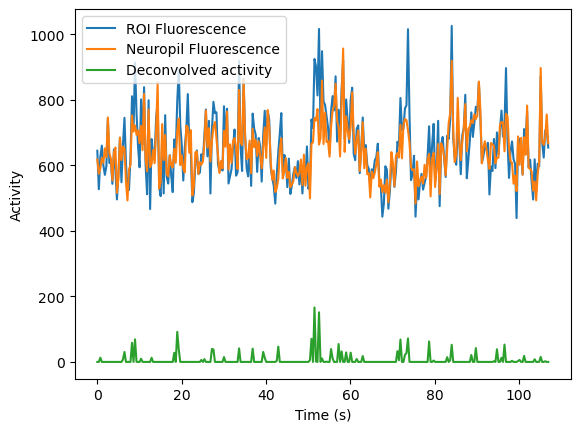

In [46]:
n_cells, n_t = outputs['F'].shape
frame_times = n.arange(n_t) / outputs['fs']
example_cell = 5500
plt.plot(frame_times, outputs['F'][example_cell], label='ROI Fluorescence')
plt.plot(frame_times, outputs['Fneu'][example_cell], label='Neuropil Fluorescence')
plt.plot(frame_times, outputs['spks'][example_cell], label='Deconvolved activity')
plt.legend()
plt.xlabel("Time (s)")
plt.ylabel("Activity")

In [47]:
# results of your manual curation will be saved here
# ROIs that are marked as cells will be 1, non-cells 0
iscell = outputs['iscell_curated_slider']

In [ ]:
# suite2p-style list of all cells
cell_stats = outputs['stats']
print(cell_stats[example_cell].keys())

In [ ]:
cell_coords = [stat['coords'] for stat in cell_stats]
cell_centers = n.array([stat['med'] for stat in cell_stats])
vmap_shape = outputs['vmap'].shape

In [ ]:
# make a volume with the footprints of all cells and plot a max-projection of it along z
cell_vol = ui.fill_cells_vol(cell_coords, fill_vals = n.ones(len(cell_coords)), empty=0)
tfu.show_tif((cell_vol ).max(axis=0))

In [ ]:
hist,bins = n.histogram(cell_centers[:,0],bins = n.arange(vmap_shape[0]))
bins = bins[:-1]

plt.plot(hist, bins)
plt.xlabel("# of neurons at a given depth")
plt.ylabel("Depth from surface (um)")
plt.yticks(n.arange(bins.max(),0,-bins.max()//6), -15*(bins.max()-n.arange(bins.max(),0,-bins.max()//6)));

# from the plot, seems like the shallowest plane has lots of cells, 
# possibly because it's out of the brain and it's mostly noise...
# it might be a good idea to exclude them in the curation 
# probably, when you have a longer recording you won't have this issue as much

### Save a fancy 3D plot
Use UCSF Chimera to open the .mrc file and visualize your cells

In [57]:
v1, v2 = ui.make_label_vols(outputs['stats'], outputs['vmap'].shape, 
            iscell =  outputs['iscell_curated_slider'], 
                  cmap='Blues', lam_max = 0.3)

In [58]:
tfu.save_mrc(combined_dir, 'curated_cells.mrc',v2[:,:,:,3], voxel_size=(4,4,15))